#Bob Ross Paintings

Team ID: B1 Team 3

Team Members: Yu-Jiun(Janice) Zou

This notebook builds on M3. The following components remain unchanged:


*   EDA and Integrated Analysis
*   M3-Method 1: Hierarchical Clustering
*   M3-Method 2: Association Rule Mining



**New From M4 (Yujun Zou)**


*   DBSCAN (density-based clustering for refined palette structure)
*   Bag-of-Words (BoW) analysis of painting titles






#EDA

##0.Load and Explore the Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
bob_ross = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-21/bob_ross.csv')

In [65]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

##1.Data Overview

In [5]:
print(f"Dataset size: {bob_ross.shape}")
print("\nColumn types:")

display(bob_ross.head())

Dataset size: (403, 27)

Column types:


,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


In [6]:
bob_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   painting_index    403 non-null    int64 
 1   img_src           403 non-null    object
 2   painting_title    403 non-null    object
 3   season            403 non-null    int64 
 4   episode           403 non-null    int64 
 5   num_colors        403 non-null    int64 
 6   youtube_src       403 non-null    object
 7   colors            403 non-null    object
 8   color_hex         403 non-null    object
 9   Black_Gesso       403 non-null    bool  
 10  Bright_Red        403 non-null    bool  
 11  Burnt_Umber       403 non-null    bool  
 12  Cadmium_Yellow    403 non-null    bool  
 13  Dark_Sienna       403 non-null    bool  
 14  Indian_Red        403 non-null    bool  
 15  Indian_Yellow     403 non-null    bool  
 16  Liquid_Black      403 non-null    bool  
 17  Liquid_Clear    

In [7]:
#sns.pairplot(bob_ross)

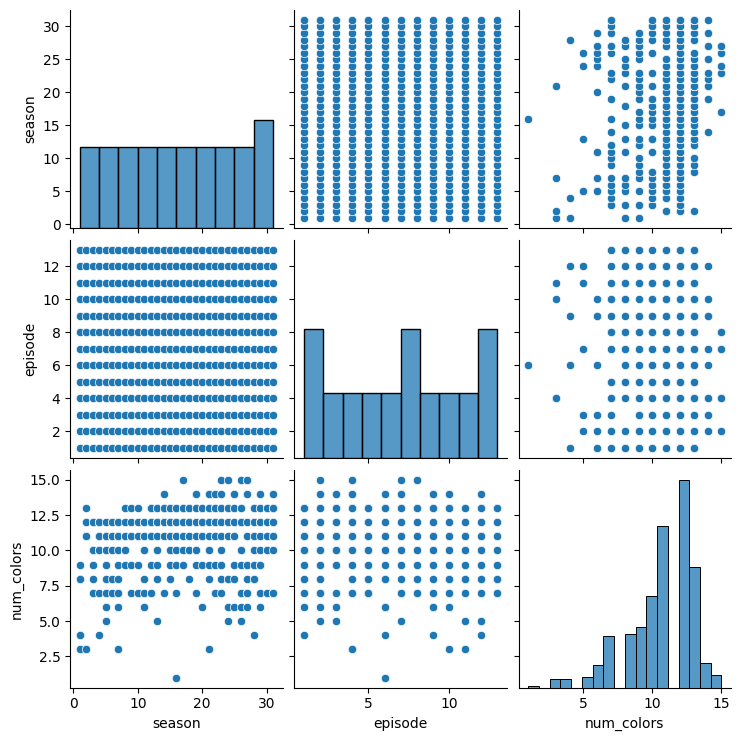

In [8]:
#Show small group
num_small = bob_ross[["season","episode","num_colors"]].copy()

sns.pairplot(num_small)
plt.show()

The pairplot shows that the number of colors used in Bob Ross paintings is fairly consistent across seasons and episodes, with no stong temporal trend. This suggests that painting complexity is not driven by time but by artistic style.

##2.Checking for Missing Values and Duplicates

###2.1 Missing Values

In [9]:
if "colors_list" in bob_ross.columns:
    bob_ross = bob_ross.drop(columns=["colors_list"])
if "hex_list" in bob_ross.columns:
    bob_ross = bob_ross.drop(columns=["hex_list"])

# Missing Values
missing = bob_ross.isna().sum()
print("Total missing cells:", int(missing.sum()))

missing_cols = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:")
if len(missing_cols) == 0:
    print("No missing values.")
else:
    display(missing_cols)

Total missing cells: 0
Columns with missing values:
No missing values.


We checked missing values across all columns and the output shows no missing values.

###2.2 Duplicates

In [10]:
# Duplicates
dup_painting_index = bob_ross["painting_index"].duplicated().sum()
print("Duplicate painting_index:", dup_painting_index)

dup_season_episode = bob_ross.duplicated(subset=["season", "episode"]).sum()
print("Duplicate (season, episode):", dup_season_episode)

if dup_season_episode > 0:
    dup_rows = bob_ross[bob_ross.duplicated(subset=["season","episode"], keep=False)]
    display(dup_rows[["painting_index","season","episode","painting_title"]].sort_values(["season","episode"]))

Duplicate painting_index: 0
Duplicate (season, episode): 0


We checked duplicates using two identifiers. Painting_index and the natural key (season, episode). The results show no duplicates.

###2.3 Range Checks

In [11]:
# Range Checks
print("season min/max:", bob_ross["season"].min(), bob_ross["season"].max())
print("episode min/max:", bob_ross["episode"].min(), bob_ross["episode"].max())
print("num_colors min/max:", bob_ross["num_colors"].min(), bob_ross["num_colors"].max())

display(bob_ross[["season","episode","num_colors"]].describe())

season min/max: 1 31
episode min/max: 1 13
num_colors min/max: 1 15


,season,episode,num_colors
count,403.00000,403.000000,403.000000
mean,16.00000,7.000000,10.605459
std,8.95539,3.746308,2.378525
min,1.00000,1.000000,1.000000
25%,8.00000,4.000000,9.000000
50%,16.00000,7.000000,11.000000
75%,24.00000,10.000000,12.000000
max,31.00000,13.000000,15.000000


##3.Variable Exploration

###3.1 Summary statistics

In [12]:
# Summary Statistics
print("Summary statistics of num_colors:")
display(bob_ross["num_colors"].describe())

Summary statistics of num_colors:


,num_colors
count,403.000000
mean,10.605459
std,2.378525
min,1.000000
25%,9.000000
50%,11.000000
75%,12.000000
max,15.000000


###3.2 Distribution

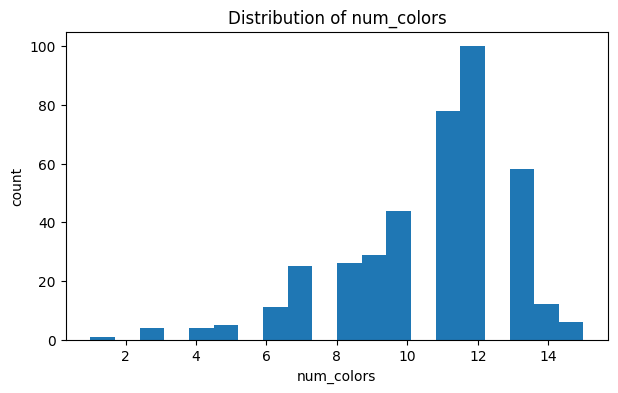

In [13]:
# Distribution of num_colors
plt.figure(figsize=(7,4))
plt.hist(bob_ross["num_colors"], bins=20)
plt.title("Distribution of num_colors")
plt.xlabel("num_colors")
plt.ylabel("count")
plt.show()

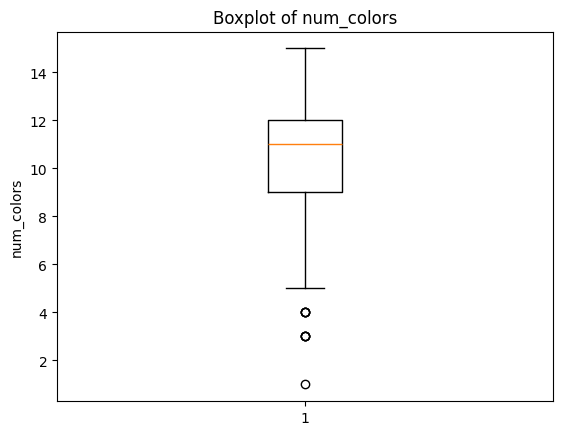

In [14]:
plt.figure()
plt.boxplot(bob_ross["num_colors"].dropna())
plt.title("Boxplot of num_colors")
plt.ylabel("num_colors")
plt.show()


The distribution of colors shows that most paintings use a moderate number of colors (9-13), indicating a consistent of visual complexity across works.

The boxplot shows that hte number of colors used in the paintings is tightly concentrated around the median, with only a few outliers.

###3.3 Extremes

In [15]:
# show extremes
min_row = bob_ross.loc[bob_ross["num_colors"].idxmin(), ["painting_title","season","episode","num_colors"]]
max_val = bob_ross["num_colors"].max()
max_rows = bob_ross.loc[bob_ross["num_colors"] == max_val, ["painting_title","season","episode","num_colors"]]

print("Min num_colors example:")
display(min_row.to_frame().T)

print("Max num_colors examples (first 10):")
display(max_rows.head(10))

Min num_colors example:


,painting_title,season,episode,num_colors
200,Contemplative Lady,16,6,1


Max num_colors examples (first 10):


,painting_title,season,episode,num_colors
214,Spectacular Waterfall,17,7,15
293,Valley Waterfall,23,8,15
306,Graceful Waterfall,24,8,15
328,Lake in the Valley,26,4,15
339,Angler's Haven,27,2,15
341,Wilderness Falls,27,4,15


Extreme cases shows that paintings with very few colors are rare, while paintings with the maximum number of colors tend to be more complex, this suggests that it captures the differences in painting style rather than random variation.

Several high number of colors paintings have related to natural secnes such as waterfalls or landscpes, suggesting that visually rich scenes may be associated with higher color usage.

##4.Identify Paint Indicator Columns and Imbalance

In [16]:
paint_bool_cols = bob_ross.select_dtypes(include=["bool"]).columns.tolist()
print("Number of boolean paint columns:", len(paint_bool_cols))
print("Example paint columns:", paint_bool_cols[:8])

X_paint_df = bob_ross[paint_bool_cols].astype(int)

X_paint_bool = X_paint_df.to_numpy(dtype=bool)

Number of boolean paint columns: 18
Example paint columns: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black']


In [17]:
exclude = {"painting_index","img_src","painting_title","season","episode","num_colors",
           "youtube_src","colors","color_hex"}

paint_like_cols = []
for c in bob_ross.columns:
    if c in exclude:
        continue
    if bob_ross[c].dtype == bool:
        paint_like_cols.append(c)
    else:
        vals = set(bob_ross[c].dropna().unique())
        if vals.issubset({0, 1}):
            paint_like_cols.append(c)

print("Number of paint-like columns:", len(paint_like_cols))

Number of paint-like columns: 18


The dataset contains 18 binary paint indicator columns, each representing whether a specific color is used in a painting.

In [18]:
X = bob_ross[paint_bool_cols].copy()

for c in paint_bool_cols:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)

usage_rate = X.mean().sort_values(ascending=False)

print("Top 10 most used paints:")
display(usage_rate.head(10))

print("Bottom 10 least used paints:")
display(usage_rate.tail(10))


Top 10 most used paints:


,0
Titanium_White,0.992556
Alizarin_Crimson,0.942928
Van_Dyke_Brown,0.920596
Cadmium_Yellow,0.858561
Yellow_Ochre,0.811414
Phthalo_Blue,0.801489
Bright_Red,0.796526
Midnight_Black,0.786600
Sap_Green,0.759305
Indian_Yellow,0.724566


Bottom 10 least used paints:


,0
Sap_Green,0.759305
Indian_Yellow,0.724566
Dark_Sienna,0.719603
Prussian_Blue,0.652605
Phthalo_Green,0.287841
Black_Gesso,0.250620
Burnt_Umber,0.136476
Liquid_Clear,0.126551
Liquid_Black,0.034739
Indian_Red,0.002481


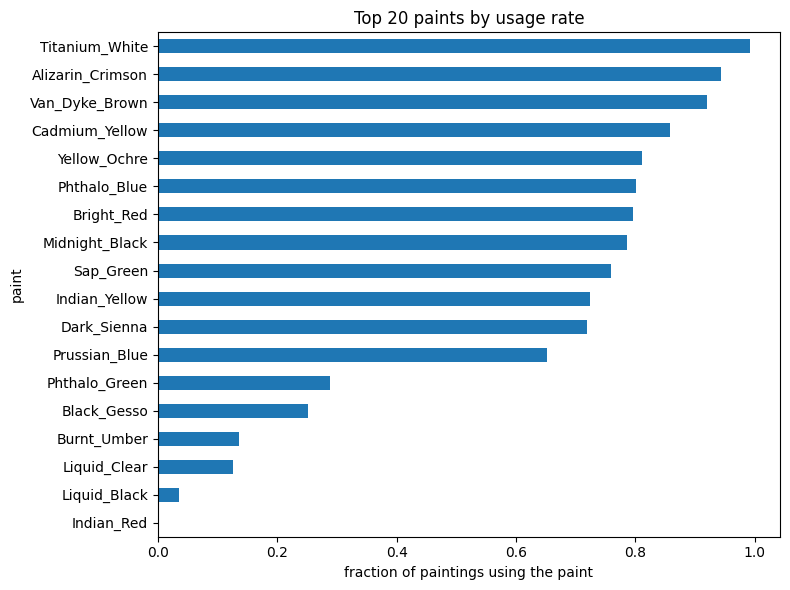

In [19]:
# Plot top 20 usage rates
topN = 20
plt.figure(figsize=(8,6))
usage_rate.head(topN).sort_values().plot(kind="barh")
plt.title(f"Top {topN} paints by usage rate")
plt.xlabel("fraction of paintings using the paint")
plt.ylabel("paint")
plt.tight_layout()
plt.show()

Paint usage is also highly imbalanced across the 18 indicators, where a small set of core paints appears in nearly all paintings, most notably Titanium White (0.9926), Alizarin Crimson (0.9429), and Van Dyke Brown (0.9206).

##5.Season patterns

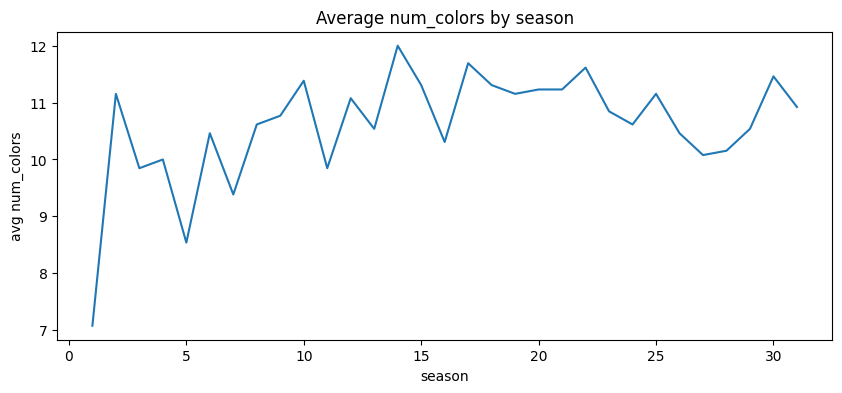

In [20]:
season_mean = bob_ross.groupby("season")["num_colors"].mean()

plt.figure(figsize=(10,4))
plt.plot(season_mean.index, season_mean.values)
plt.title("Average num_colors by season")
plt.xlabel("season")
plt.ylabel("avg num_colors")
plt.show()

The average number of colors per painting increases silghty and becomes more stable across later seasons. This suggests that Bob Ross's painting style converged to a consistent level of color complexity over time.

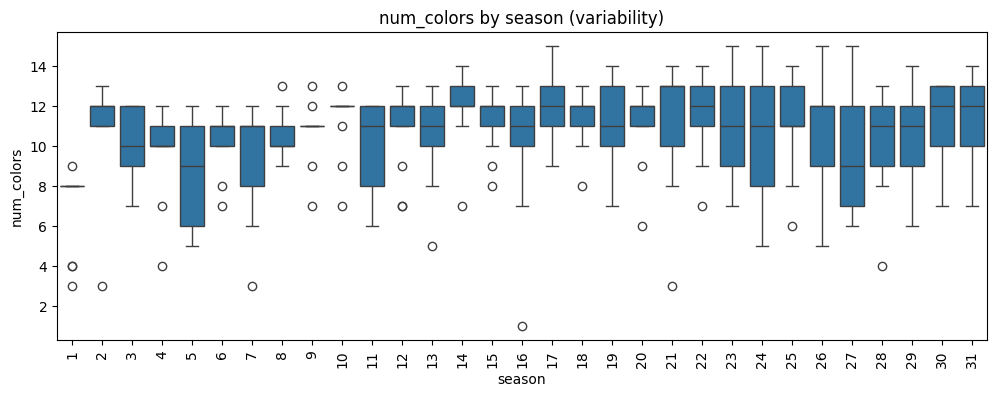

In [21]:
plt.figure(figsize=(12,4))
sns.boxplot(x="season", y="num_colors", data=bob_ross)
plt.title("num_colors by season (variability)")
plt.xticks(rotation=90)
plt.show()

This boxplot shows that while the average number of colors per painting is relatively stable across seasons, some seasons show much greater variation.

Later seasons show reduced extremely low color counts, but greater spread among mediun to high color usage, suggesting that paintings become consistently more complex while still varies between paintings.

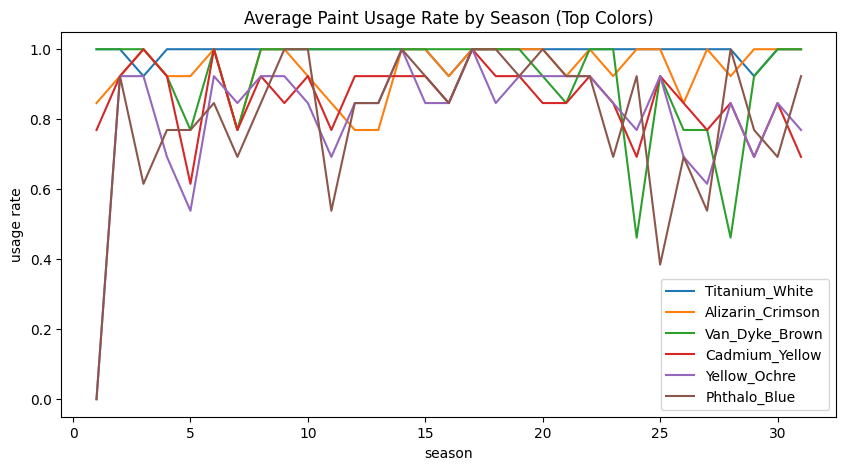

In [22]:
top_paints = usage_rate.head(6).index.tolist()
season_paint = X.join(bob_ross["season"]).groupby("season")[top_paints].mean()

plt.figure(figsize=(10,5))
for c in top_paints:
    plt.plot(season_paint.index, season_paint[c], label=c)
plt.title("Average Paint Usage Rate by Season (Top Colors)")
plt.xlabel("season")
plt.ylabel("usage rate")
plt.legend()
plt.show()


The most frequently used paints maintain consistently high usage rates across seasons, showing a stable core palette in Bob Ross's paintings, while a smaller number of colors reflect seasonal fluctuations.

The coexistence of stable and variable paint usage suggests both core features and seasons-dependent variation in painting styles, making it suitable for futher clustering.



##6.Co-occurrence

<Axes: >

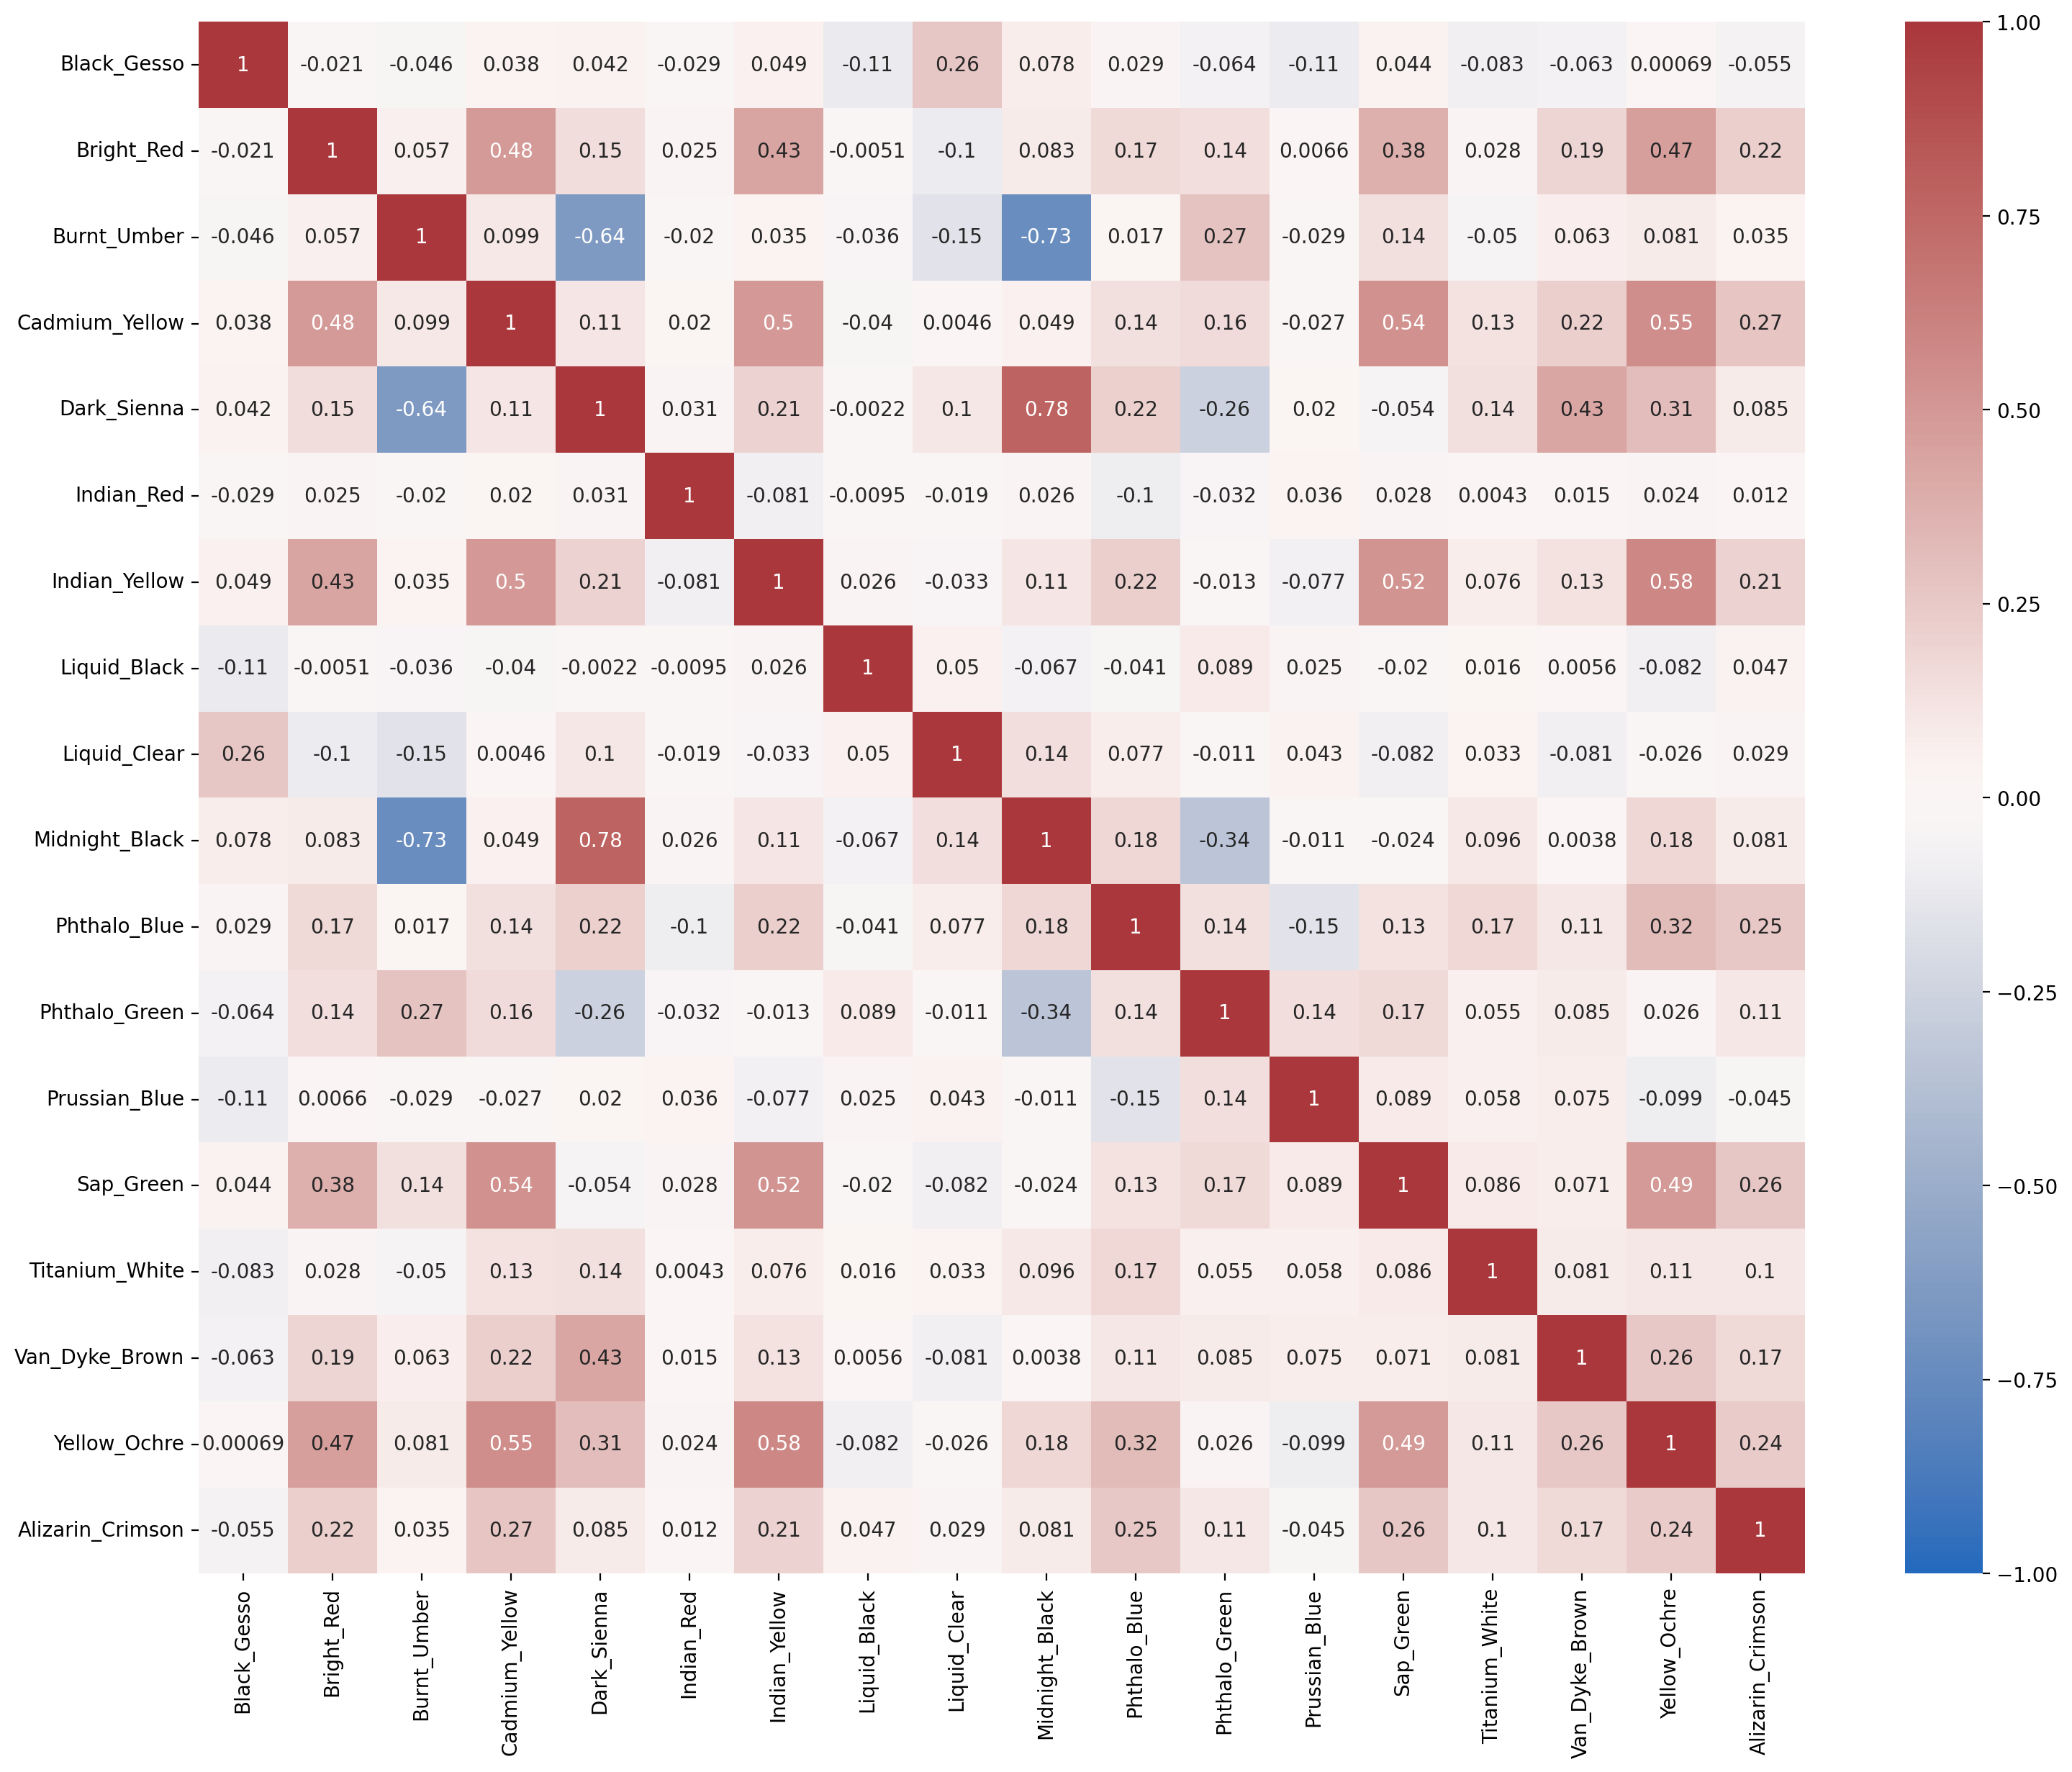

In [23]:
corr = X.corr(numeric_only=True)

plt.figure(figsize=(18, 14), dpi=200)
sns.heatmap(corr, annot=True, cmap="vlag" , vmin=-1, vmax=1)

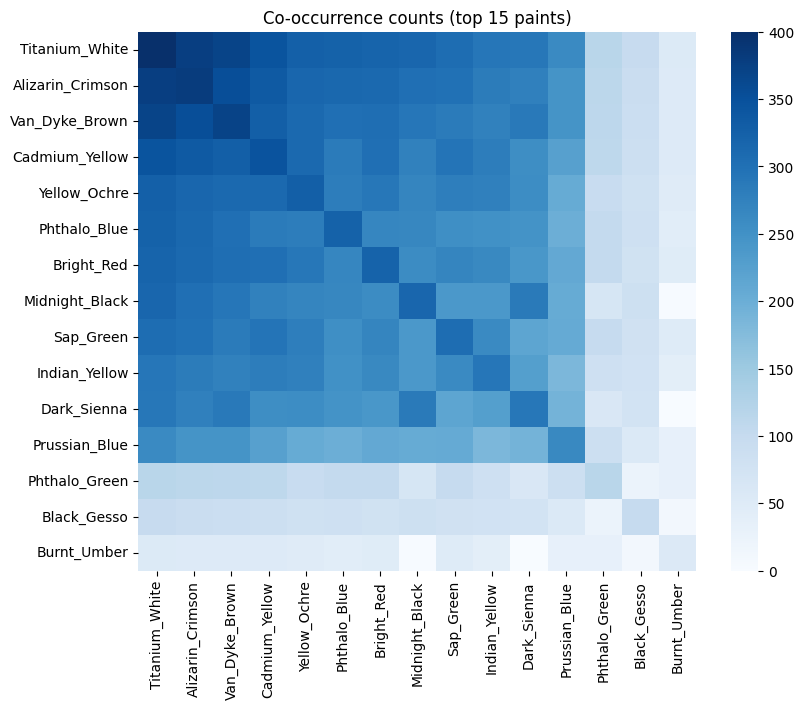

In [24]:
co = X.T.dot(X)

topM = 15
top_list = usage_rate.head(topM).index.tolist()
co_top = co.loc[top_list, top_list]

plt.figure(figsize=(9,7))
sns.heatmap(co_top, cmap="Blues")
plt.title(f"Co-occurrence counts (top {topM} paints)")
plt.show()

In [25]:
pairs = []
for i in range(len(top_list)):
    for j in range(i+1, len(top_list)):
        a = top_list[i]
        b = top_list[j]
        pairs.append([a, b, int(co.loc[a, b])])

pairs_df = pd.DataFrame(pairs, columns=["paint_a","paint_b","co_count"])
pairs_df = pairs_df.sort_values("co_count", ascending=False)

print("Top 15 co-occurring paint pairs:")
display(pairs_df.head(15))

Top 15 co-occurring paint pairs:


,paint_a,paint_b,co_count
0,Titanium_White,Alizarin_Crimson,378
1,Titanium_White,Van_Dyke_Brown,369
14,Alizarin_Crimson,Van_Dyke_Brown,354
2,Titanium_White,Cadmium_Yellow,345
15,Alizarin_Crimson,Cadmium_Yellow,335
27,Van_Dyke_Brown,Cadmium_Yellow,327
3,Titanium_White,Yellow_Ochre,326
4,Titanium_White,Phthalo_Blue,323
5,Titanium_White,Bright_Red,319
16,Alizarin_Crimson,Yellow_Ochre,317


The co-occurrence heatmap reveals overall grouping patterns among paints, with the top co-occurrence paint pairs table highlights the exact paint pairs that drive those patterns, suggesting systematic combinations rather than independent choices.

##7.Similarity

###7.1 Similarity Distribution

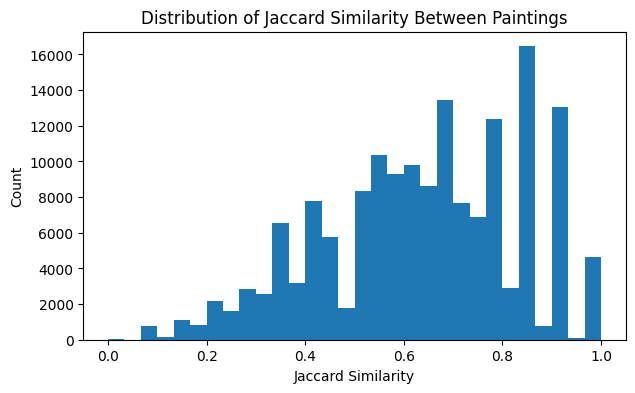

In [26]:
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

D = pairwise_distances(X_paint_bool, metric="jaccard")
S = 1 - D

np.fill_diagonal(S, np.nan)
sim_vals = S[~np.isnan(S)].ravel()

plt.figure(figsize=(7,4))
plt.hist(sim_vals, bins=30)
plt.title("Distribution of Jaccard Similarity Between Paintings")
plt.xlabel("Jaccard Similarity")
plt.ylabel("Count")
plt.show()

In [27]:
print("Similarity summary:")
print(pd.Series(sim_vals).describe())

Similarity summary:
count    162006.000000
mean          0.634615
std           0.200912
min           0.000000
25%           0.500000
50%           0.642857
75%           0.785714
max           1.000000
dtype: float64


The similarity distribution shows that most paintings share a moderate to high level of paint overlap, and the most common exact paint recipe appears in dozens of paintings. This pattern indicates a consistent core palette across Bob Ross's work.

This similarity structure motivate the use of clustering methods to identify goups of paintings with similar color palettes.

###7.2 Nearest Neighbors

In [28]:
meta_cols = ["painting_index", "season", "episode", "painting_title", "num_colors"]
meta_cols = [c for c in meta_cols if c in bob_ross.columns]

def topk_neighbors(i, k=5, S_mat=None):
    sims = S_mat[i].copy()
    sims[i] = -np.inf
    nn_idx = np.argsort(sims)[-k:][::-1]
    return nn_idx, sims[nn_idx]

example_i = 2
nn_idx, nn_sim = topk_neighbors(example_i, k=5, S_mat=S)

print("Query painting:")
display(bob_ross.loc[[example_i], meta_cols])

Query painting:


,painting_index,season,episode,painting_title,num_colors
2,284,1,3,Ebony Sunset,9


In [29]:
neighbors = bob_ross.loc[nn_idx, meta_cols].copy()
neighbors["jaccard_similarity"] = nn_sim
print("Top-5 nearest neighbors:")
display(neighbors)

Top-5 nearest neighbors:


,painting_index,season,episode,painting_title,num_colors,jaccard_similarity
0,282,1,1,A Walk in the Woods,8,0.888889
12,294,1,13,Final Reflections,8,0.888889
7,289,1,8,Peaceful Valley,8,0.888889
6,288,1,7,Autumn Mountain,8,0.888889
4,286,1,5,Quiet Stream,8,0.888889


We compute Jaccard similarity between paintings based on paint usage and retrieve the top-k nearest neighbors for a selected painting.

The nearest neighbors of the query painting show very high Jaccard similarity and similar palette sizes, indicating that paintings using nearly identical sets of paints are correctly idetified as similar.

###7.3 Near-duplicates

In [30]:
n = len(bob_ross)
pairs = []

for i in range(n):
    for j in range(i+1, n):
        pairs.append((i, j, S[i, j]))

pairs_df = pd.DataFrame(pairs, columns=["i", "j", "jaccard_similarity"]).sort_values(
    "jaccard_similarity", ascending=False
)

print("Top 20 most similar pairs:")
display(pairs_df.head(20))

threshold = 0.95
near_dup = pairs_df[pairs_df["jaccard_similarity"] >= threshold]
print(f"Number of pairs with similarity >= {threshold}: {len(near_dup)}")
display(near_dup.head(20))

Top 20 most similar pairs:


,i,j,jaccard_similarity
70531,257,371,1.0
70528,257,368,1.0
70664,258,360,1.0
70516,257,356,1.0
70513,257,353,1.0
70511,257,351,1.0
70496,257,336,1.0
70492,257,332,1.0
70487,257,327,1.0
70479,257,319,1.0


Number of pairs with similarity >= 0.95: 2330


,i,j,jaccard_similarity
70531,257,371,1.0
70528,257,368,1.0
70664,258,360,1.0
70516,257,356,1.0
70513,257,353,1.0
70511,257,351,1.0
70496,257,336,1.0
70492,257,332,1.0
70487,257,327,1.0
70479,257,319,1.0


In [31]:
recipe_sizes = (
    bob_ross.groupby(paint_bool_cols, dropna=False)
            .size()
            .sort_values(ascending=False)
            .reset_index(name="n_paintings")
)

print("Top 10 most common exact paint recipes:")
display(recipe_sizes.head(10))

top_recipe = recipe_sizes.loc[0, paint_bool_cols].to_dict()

mask = np.ones(len(bob_ross), dtype=bool)
for c in paint_bool_cols:
    mask &= (bob_ross[c] == top_recipe[c])

meta_cols = ["painting_index", "season", "episode", "painting_title", "num_colors"]
meta_cols = [c for c in meta_cols if c in bob_ross.columns]

print("Paintings using the most common recipe:")
display(bob_ross.loc[mask, meta_cols].sort_values(["season", "episode"]))

Top 10 most common exact paint recipes:


,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson,n_paintings
0,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True,46
1,False,True,False,True,True,False,True,False,False,True,True,True,True,True,True,True,True,True,32
2,False,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,True,24
3,True,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,True,17
4,False,True,False,True,True,False,True,False,False,True,False,False,True,True,True,True,True,True,14
5,False,True,True,True,False,False,True,False,False,False,True,True,True,True,True,True,True,True,13
6,True,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True,9
7,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,9
8,False,True,True,True,False,False,True,False,False,False,True,True,False,True,True,True,True,True,8
9,False,False,False,False,True,False,False,False,False,True,True,False,True,False,True,True,False,True,7


Paintings using the most common recipe:


,painting_index,season,episode,painting_title,num_colors
118,164,10,2,Cabin at Sunset,12
119,165,10,3,Twin Falls,12
120,166,10,4,Secluded Bridge,12
122,168,10,6,Autumn Woods,12
127,174,10,11,Triple View,12
129,176,10,13,Lakeside Cabin,12
130,150,11,1,Mountain Stream,12
133,153,11,4,Hidden Stream,12
136,156,11,7,Lakeside Path,12
144,138,12,2,Mountain Reflections,12


In [32]:
cols = ["n_paintings"] + paint_bool_cols
display(recipe_sizes[cols].head(10))

,n_paintings,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,46,False,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True
1,32,False,True,False,True,True,False,True,False,False,True,True,True,True,True,True,True,True,True
2,24,False,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,True
3,17,True,True,False,True,True,False,True,False,False,True,True,False,False,True,True,True,True,True
4,14,False,True,False,True,True,False,True,False,False,True,False,False,True,True,True,True,True,True
5,13,False,True,True,True,False,False,True,False,False,False,True,True,True,True,True,True,True,True
6,9,True,True,False,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True
7,9,False,True,False,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True
8,8,False,True,True,True,False,False,True,False,False,False,True,True,False,True,True,True,True,True
9,7,False,False,False,False,True,False,False,False,False,True,True,False,True,False,True,True,False,True


,count
season,
10,6
11,3
12,4
13,3
14,2
15,4
16,1
17,1
18,1


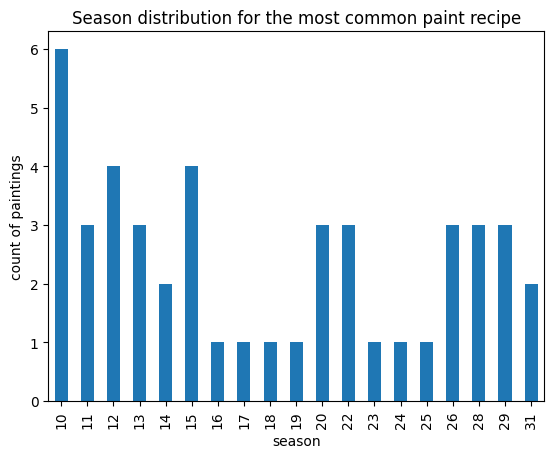

In [33]:
top_recipe_paintings = bob_ross.loc[mask].copy()

season_counts = top_recipe_paintings["season"].value_counts().sort_index()
display(season_counts)

plt.figure()
season_counts.plot(kind="bar")
plt.title("Season distribution for the most common paint recipe")
plt.xlabel("season")
plt.ylabel("count of paintings")
plt.show()

Using a near-duplicate threshold of 0.95, we identified 2,330 highly similar pairs, indicating substantial repetition or templating in palette composition. This tendency is also evident at the exact-recipe level, where the most frequent paint recipe appears in 46 paintings.

In conculsion, the results suggest that palette choices follow a small set of recurring templates with limited variation, creating clear opportunities to define interpretable groupings and boundaries within an otherwise consistent instructional series.

##8.Correlation

Number of paint columns: 18


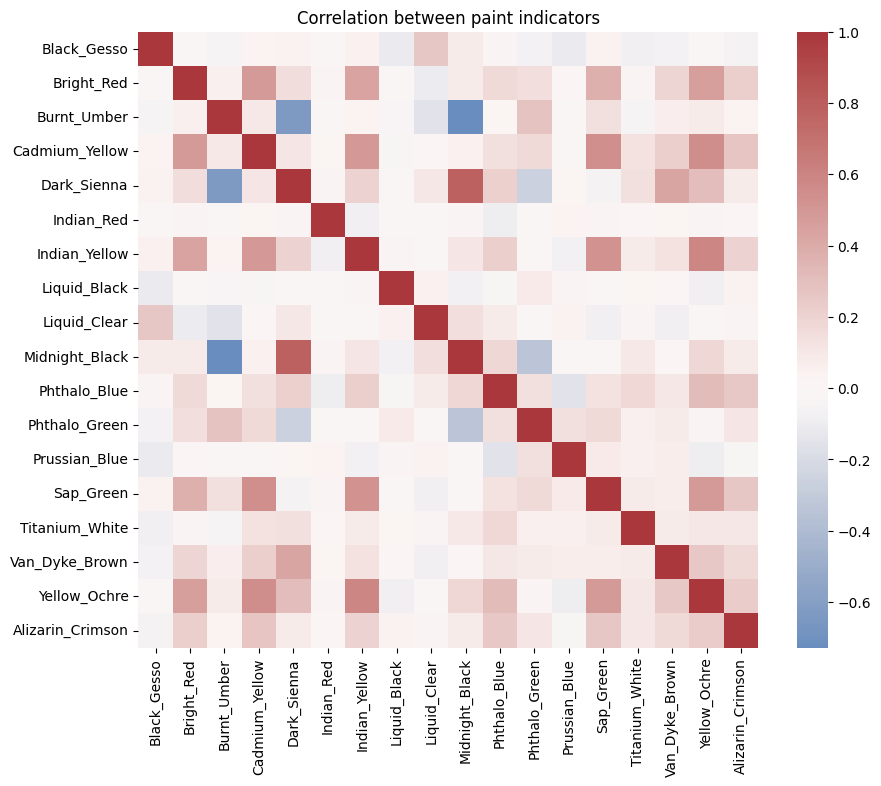

In [34]:
paint_cols = []
for c in bob_ross.columns:
    if bob_ross[c].dtype == bool:
        paint_cols.append(c)
    else:
        vals = bob_ross[c].dropna().unique()
        if len(vals) > 0 and set(vals).issubset({0, 1}):
            if c not in ["painting_index", "season", "episode", "num_colors"]:
                paint_cols.append(c)

print("Number of paint columns:", len(paint_cols))

X = bob_ross[paint_cols].copy()
for c in paint_cols:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)

corr_paint = X.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_paint, cmap="vlag", center=0)
plt.title("Correlation between paint indicators")
plt.show()

The correlation heatmap shows that most paint indicators have weak pairwise correlations, indicating that individual paint choices are largely independent. However, a small number of paint pairs exhibit moderate positive correlations, suggesting stable co-usage patterns, while a few negative correlations indicate substitute relationships.

## 9.Text Analysis

###9.1 Text Distribution

In [35]:
bob_ross["title_len"] = bob_ross["painting_title"].str.split().apply(len)
bob_ross["title_len"].describe()

,title_len
count,403.000000
mean,2.454094
std,0.785282
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,5.000000


The painting titles are generally short, with a median length of two words and a maximum of five words. This indicates that titles tend to emphasize a small number of salient concepts rather than detailed descriptions.

In [36]:
from collections import Counter

words = (bob_ross["painting_title"].str.lower()
    .str.replace("[^a-z ]", "", regex=True)
    .str.split()
    .sum())
stopwords = {"the", "of", "a", "in", "on", "at", "and"}

words_clean = [w for w in words if w not in stopwords]
word_freq = Counter(words_clean)

In [37]:
filtered_words = pd.Series(words_clean)
filtered_words.value_counts().head(10)

,count
mountain,45
winter,37
oval,21
autumn,18
lake,16
cabin,15
sunset,13
stream,11
waterfall,11
forest,10


Frequent title words are dominated by landscape features, seasonal references, and natural scenery, suggesting a strong thematic consistency in how paintings are named.

In [38]:
keyword_groups = {
    "landscape": {"mountain", "valley", "meadow", "forest", "woods"},
    "water": {"lake", "river", "stream", "waterfall", "falls"},
    "season_time": {"winter", "autumn", "day", "sunset"},
    "objects_view": {"cabin", "barn", "view", "oval"},}

dim_counts = {
    dim: sum(w in kws for w in words_clean)
    for dim, kws in keyword_groups.items()}

pd.Series(dim_counts)

,0
landscape,79
water,54
season_time,78
objects_view,54


Aggregating title words into thematic groups reveals that landscape and seasonal references are the most prominent dimensions, followed by water-related features and specific scenic objects. This structured distribution suggests that painting titles encode recurring high-level themes rather than isolated keywords.

###9.2 Text Similarity

In [39]:
import re
title_sets = (
    bob_ross["painting_title"]
    .str.lower()
    .str.replace(r"[^a-z ]", "", regex=True)
    .str.split()
    .apply(set))

In [40]:
n = len(title_sets)
S_text = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        A = title_sets.iloc[i]
        B = title_sets.iloc[j]
        if len(A | B) > 0:
            sim = len(A & B) / len(A | B)
        else:
            sim = 0
        S_text[i, j] = sim
        S_text[j, i] = sim

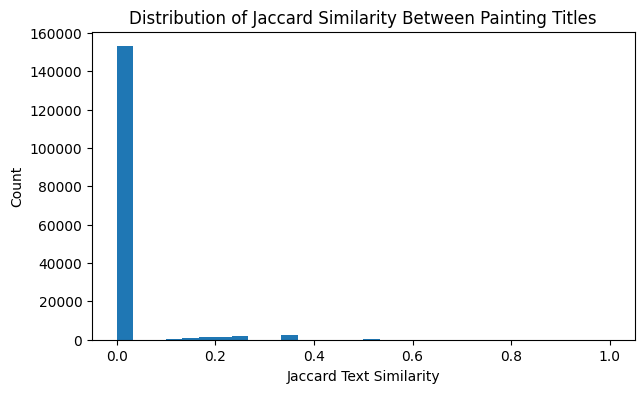

In [41]:
np.fill_diagonal(S_text, np.nan)
sim_text_vals = S_text[~np.isnan(S_text)].ravel()


plt.figure(figsize=(7,4))
plt.hist(sim_text_vals, bins=30)
plt.xlabel("Jaccard Text Similarity")
plt.ylabel("Count")
plt.title("Distribution of Jaccard Similarity Between Painting Titles")
plt.show()


Pairwise Jaccard similarity between painting titles is heavily concentrated near zero, indicating minimal lexical overlap across most title pairs. Only a small number of pairs exhibit moderate to high similarity, reflecting occasional reuse of specific words rather than pervasive redundancy.

##Summary of our EDA

The dataset has 403 paintings and 18 ninary paint indicators. We did not find missing values or duplicate rows in the fields used for analysis.Paint usage across the 18 indicators is highly imbalanced. A small core set of colors, especially Titanium White (0.9926), Alizarin Crimson (0.9429), and Van Dyke Brown (0.9206), appears in almost every painting. These core colors also show strong co-occurrence, suggesting the presence of a shared base palette across most works.

Pairwise Jaccard similarity analysis revealed a high level of overlap in palette usage between paintings, with a median above 0.64 and many near-duplicate palette combinations. Several exact paint combinations appeared repeatedly across dozens of paintings. Temporal exploration further showed little change in average paint usage across seasons, indicating that palette structure remains largely stable over time.

In addition to palette analysis, exploratory text analysis of painting titles showed that titles are typically short and emphasize a small number of key concepts. Frequent words are dominated by landscape features, seasonal references, and natural scenery, suggesting strong thematic consistency in how paintings are described. When grouped into broader themes, landscape and seasonal categories emerged as the most prominent dimensions, indicating that titles capture recurring high-level motifs rather than detailed descriptions.

Together, these findings suggest that both palette usage and thematic framing in Bob Ross’s paintings are highly consistent and structured rather than random. However, the EDA mainly focuses on frequencies, co-occurrence patterns, similarity measures, and thematic aggregation. While these analyses describe overall regularity and repetition, they do not determine whether the observed patterns reflect a single dominant palette template or multiple closely related palette structures. This limitation motivates the use of clustering methods to further examine the underlying structure of palette usage.


#Integrated Analysis & Synergy

##M3 Method 1

### Hierarchical Clustering

####1.1 Comparing Jaccard and Hamming

In [42]:
X_bool = X.to_numpy(dtype=bool)
D_jaccard = pairwise_distances(X_bool, metric="jaccard")

In [43]:
# Compute Distance Matrices
D_hamming = pairwise_distances(X_bool, metric="hamming")

print(f"Jaccard distance range: [{D_jaccard.min():.3f}, {D_jaccard.max():.3f}]")
print(f"Hamming distance range: [{D_hamming.min():.3f}, {D_hamming.max():.3f}]")

Jaccard distance range: [0.000, 1.000]
Hamming distance range: [0.000, 0.778]


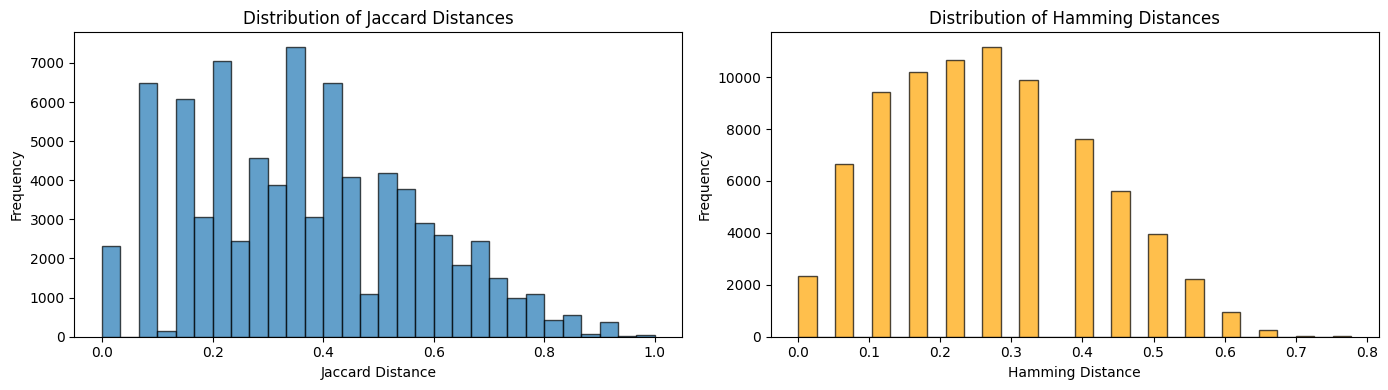

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

mask = np.triu(np.ones_like(D_jaccard, dtype=bool), k=1)
jaccard_vals = D_jaccard[mask]
hamming_vals = D_hamming[mask]

axes[0].hist(jaccard_vals, bins=30, edgecolor="black", alpha=0.7)
axes[0].set_title("Distribution of Jaccard Distances")
axes[0].set_xlabel("Jaccard Distance")
axes[0].set_ylabel("Frequency")

axes[1].hist(hamming_vals, bins=30, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_title("Distribution of Hamming Distances")
axes[1].set_xlabel("Hamming Distance")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

The Jaccard distances are more spread out, which means they can better distinguish differences between paintings whem we think of palettes as sets of used colors. In contrast, Hamming distances are more compressed because they cont share aabsences, making many paintings appear more similar than they actually are.

In [45]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X_paint_bool, method="average", metric="jaccard")

print("Linkage matrix shape:", Z.shape)

Linkage matrix shape: (402, 4)


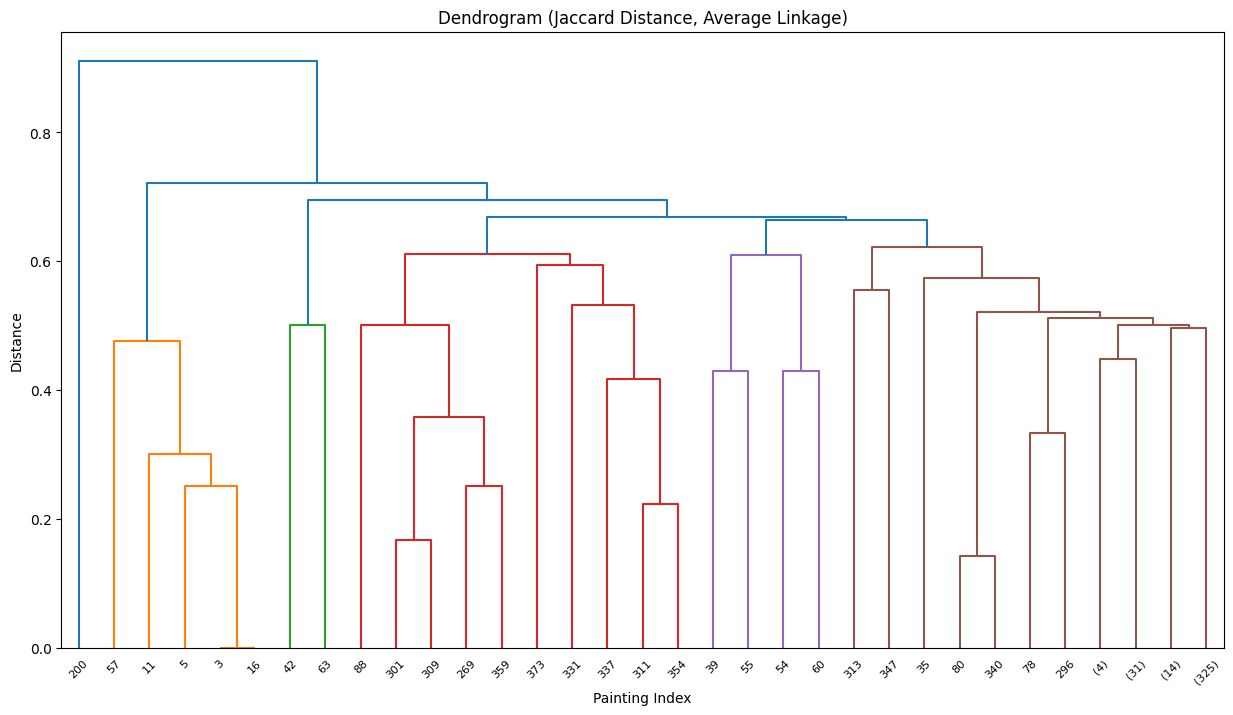

In [46]:
plt.figure(figsize=(15, 8))
dendrogram(Z, truncate_mode='level', p=10)
plt.title("Dendrogram (Jaccard Distance, Average Linkage)")
plt.xlabel("Painting Index")
plt.ylabel("Distance")
plt.show()

In [47]:
n_clusters = 5

bob_ross["cluster_labels"] = fcluster(Z, n_clusters, criterion="maxclust").astype(str)


In [48]:
bob_ross["cluster_labels"].value_counts()

,count
cluster_labels,
4,385
3,10
1,5
2,2
5,1


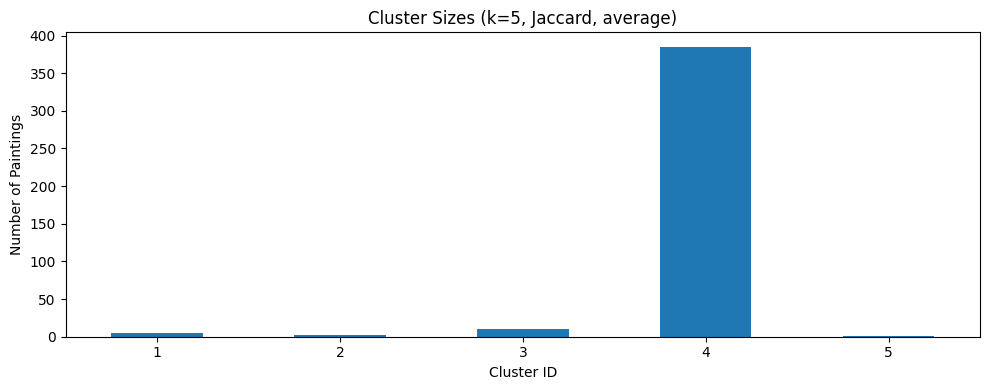

In [49]:
plt.figure(figsize=(10, 4))
bob_ross['cluster_labels'].value_counts().sort_index().plot(kind='bar')
plt.title(f"Cluster Sizes (k={n_clusters}, Jaccard, average)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Paintings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [50]:
one_rate = X.astype(int).values.mean()
print(f"Overall 1-rate: {one_rate:.3f} | 0-rate: {1-one_rate:.3f}")

Overall 1-rate: 0.589 | 0-rate: 0.411


Paint usage is sparse, so many pairs match on zeros; Hamming counts those matches, which pulls distances closer together.

In [51]:
cluster_sizes = bob_ross['cluster_labels'].value_counts().sort_index()
largest_cluster_pct = cluster_sizes.max() / len(bob_ross) * 100

print("Cluster Balance Analysis:")
print(f"  Largest cluster: {cluster_sizes.max()} paintings ({largest_cluster_pct:.1f}%)")
print(f"  Smallest cluster: {cluster_sizes.min()} paintings ({cluster_sizes.min()/len(bob_ross)*100:.1f}%)")
print(f"  Imbalance ratio: {cluster_sizes.max() / cluster_sizes.min():.1f}:1")


Cluster Balance Analysis:
  Largest cluster: 385 paintings (95.5%)
  Smallest cluster: 1 paintings (0.2%)
  Imbalance ratio: 385.0:1


In [52]:
df_cluster = X.copy()
df_cluster["cluster_labels"] = bob_ross["cluster_labels"].values
display(df_cluster.head())

,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson,cluster_labels
0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
2,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1
4,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,4


In [53]:
cluster_paint_rates = bob_ross.groupby("cluster_labels")[paint_cols].mean()
cluster_sizes = bob_ross["cluster_labels"].value_counts()
dominant = cluster_sizes.idxmax()

baseline_rate = cluster_paint_rates.loc[dominant]
eps = 1e-9

lift_vs_baseline = cluster_paint_rates.div(baseline_rate + eps, axis=1)

top_n = 8
for cl in cluster_paint_rates.index:
    if cl == dominant:
        continue
    print(f"\nCluster {cl} vs baseline {dominant}: most over-represented paints")
    top = lift_vs_baseline.loc[cl].sort_values(ascending=False).head(top_n)
    display(pd.DataFrame({
        "lift_vs_baseline": top,
        "baseline_rate": baseline_rate.loc[top.index],
        "cluster_rate": cluster_paint_rates.loc[cl, top.index],
    }))


Cluster 1 vs baseline 4: most over-represented paints


,lift_vs_baseline,baseline_rate,cluster_rate
Liquid_Black,5.923077,0.033766,0.2
Prussian_Blue,1.558704,0.641558,1.0
Van_Dyke_Brown,1.054795,0.948052,1.0
Titanium_White,1.002604,0.997403,1.0
Black_Gesso,0.819149,0.244156,0.2
Alizarin_Crimson,0.413978,0.966234,0.4
Indian_Yellow,0.267361,0.748052,0.2
Bright_Red,0.000000,0.825974,0.0



Cluster 2 vs baseline 4: most over-represented paints


,lift_vs_baseline,baseline_rate,cluster_rate
Burnt_Umber,7.264151,0.137662,1.0
Black_Gesso,2.047872,0.244156,0.5
Prussian_Blue,1.558704,0.641558,1.0
Bright_Red,1.210692,0.825974,1.0
Titanium_White,1.002604,0.997403,1.0
Indian_Yellow,0.668403,0.748052,0.5
Midnight_Black,0.625000,0.800000,0.5
Cadmium_Yellow,0.559593,0.893506,0.5



Cluster 3 vs baseline 4: most over-represented paints


,lift_vs_baseline,baseline_rate,cluster_rate
Liquid_Clear,2.406250,0.124675,0.3
Black_Gesso,2.047872,0.244156,0.5
Prussian_Blue,1.402834,0.641558,0.9
Midnight_Black,1.000000,0.800000,0.8
Titanium_White,0.902344,0.997403,0.9
Phthalo_Blue,0.728707,0.823377,0.6
Sap_Green,0.639535,0.781818,0.5
Alizarin_Crimson,0.620968,0.966234,0.6



Cluster 5 vs baseline 4: most over-represented paints


,lift_vs_baseline,baseline_rate,cluster_rate
Van_Dyke_Brown,1.054795,0.948052,1.0
Black_Gesso,0.000000,0.244156,0.0
Bright_Red,0.000000,0.825974,0.0
Burnt_Umber,0.000000,0.137662,0.0
Dark_Sienna,0.000000,0.753247,0.0
Cadmium_Yellow,0.000000,0.893506,0.0
Indian_Yellow,0.000000,0.748052,0.0
Liquid_Black,0.000000,0.033766,0.0


Since one cluster contains almost all paintings, we treat it as the baseline palette rather than an “archetype.” We then compare the other clusters to this baseline. For each paint, we compute a simple ratio: cluster usage rate divided by baseline usage rate. Ratios above 1 highlight paints that are unusually common in a small cluster.

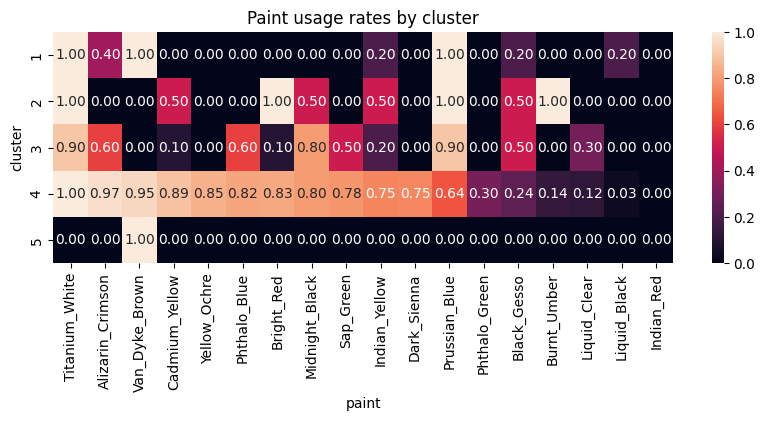

In [54]:
cluster_paint_rates = bob_ross.groupby("cluster_labels")[paint_cols].mean()

top_paints = bob_ross[paint_cols].mean().sort_values(ascending=False).index
hm = cluster_paint_rates[top_paints]

plt.figure(figsize=(10,3))
sns.heatmap(hm, annot=True, fmt=".2f")
plt.title("Paint usage rates by cluster")
plt.xlabel("paint")
plt.ylabel("cluster")
plt.show()

####1.2 Clustering with distance threshold instead of maxclust

In [55]:
cluster_threshold = [0.20, 0.40, 0.60, 0.85]
result = []
for t in cluster_threshold:
    labels =fcluster(Z, t=t, criterion="distance")
    cluster_sizes = pd.Series(labels).value_counts()
    print(f"\nCluster sizes for threshold={t}:\n{cluster_sizes}")

    n_clusters = len(np.unique(labels))
    largest_pct = cluster_sizes.max() / len(labels)
    smallest_pct = cluster_sizes.min() / len(labels)
    imbalance_ratio = cluster_sizes.max() / cluster_sizes.min()

    result.append({
        "threshold": t,
        "n_clusters": n_clusters,
        "largest_cluster_pct": largest_pct,
        "smallest_cluster_pct": smallest_pct,
        "imbalance_ratio": imbalance_ratio
    })

result_df = pd.DataFrame(result)
display(result_df)


Cluster sizes for threshold=0.2:
70    193
49     43
66     23
39     10
29      9
     ... 
21      1
12      1
9       1
15      1
54      1
Name: count, Length: 74, dtype: int64

Cluster sizes for threshold=0.4:
25    320
20     25
22     14
21      6
19      4
5       4
1       4
24      3
18      2
17      2
23      2
7       2
14      1
2       1
12      1
13      1
3       1
11      1
26      1
4       1
6       1
27      1
15      1
9       1
8       1
16      1
10      1
Name: count, dtype: int64

Cluster sizes for threshold=0.6:
8    379
1      5
3      5
4      5
5      2
6      2
2      2
7      2
9      1
Name: count, dtype: int64

Cluster sizes for threshold=0.85:
1    402
2      1
Name: count, dtype: int64


,threshold,n_clusters,largest_cluster_pct,smallest_cluster_pct,imbalance_ratio
0,0.20,74,0.478908,0.002481,193.0
1,0.40,27,0.794045,0.002481,320.0
2,0.60,9,0.940447,0.002481,379.0
3,0.85,2,0.997519,0.002481,402.0


The clustering analysis with different Jaccard distance thresholds shows a consistent pattern in Bob Ross's painting palettes. At a low threshold, it shows a high number of clusters with a relatively small largest cluster suggests significant variety in specific paint combinations. As the threshold increases, the number of clusters drastically decreases, with one dominant cluster obtaining a larger percentage of paintings. At a very high threshold, nearly all paintings merge into a single large cluster, with an extremely high imbalance ratio. This refeinforces our findings that Bob Ross predominantly used a highly consistent core palette across his body of work, with only a few variants demostrating distinct paint choices.

Since low threshold make the most seperations, so I am interested to explore:

In [56]:
labels_temp = fcluster(Z, t=0.20, criterion="distance")

temp_df_for_lowest_cluster = bob_ross.copy()
temp_df_for_lowest_cluster["cluster_labels"] = labels_temp

cluster_paint_lowest = temp_df_for_lowest_cluster.groupby("cluster_labels")[paint_cols].mean()

print("Average paint usage rates per cluster (threshold = 0.20):")
display(cluster_paint_lowest)

Average paint usage rates per cluster (threshold = 0.20):


,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
cluster_labels,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0,0.000000
2,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0,1.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,0.0,1.000000
5,1.000000,1.000000,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.259067,0.968912,0.0,1.0,1.0,0.0,1.0,0.046632,0.119171,0.994819,0.870466,0.259067,0.715026,1.0,1.0,1.0,1.0,0.989637
71,0.000000,1.000000,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000
72,0.000000,1.000000,0.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,1.000000


At threshold of 0.20, the clustering produces 74 small groups, each with a distinct paint usage pattern. Many of these smaller clusters show very specific color choices, with some paints used in 0% or 100% of the paintings within that group. This shows that while a dominant palette exists, there are also several niche and highly specialized color combinations that represent distinct stylistic variations.

Overall, we retain both clustering views because they answer different levels of the same question about Bob Ross's palette structure. The k=5 result captures the macro pattern that one much bigger cluster shows that most paintings rely on a consistent core “standard palette”. In contrast, the distance threshold t = 0.20 produces many small clusters that reveal micro-level variations. These are specialized color combinations that act as deviations within that broader palette, instead of just separate styles.

##M3 Method 2

###Association Rule

Identify paints with minimal variation across paintings

In [103]:
X_bool_df = X.astype(bool)

df_rules = X_bool_df.copy()
df_rules["cluster_labels"] = bob_ross["cluster_labels"].values

display(df_rules.head())

,arctic,autumn,barn,beach,beauty,black,blue,bridge,brook,bubbling,...,waters,waves,way,wilderness,winter,wintertime,wonder,wooded,woods,cluster_labels
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,4
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4


In [104]:
global_usage = X_paint_df.mean().sort_values(ascending=False)
display(global_usage.head(12))

TRIVIAL_THRESH = 0.95
trivial_paints = set(global_usage[global_usage >= TRIVIAL_THRESH].index)

print("Trivial paints (global usage >= 0.95):")
print(sorted(list(trivial_paints)))

,0
Titanium_White,0.992556
Alizarin_Crimson,0.942928
Van_Dyke_Brown,0.920596
Cadmium_Yellow,0.858561
Yellow_Ochre,0.811414
Phthalo_Blue,0.801489
Bright_Red,0.796526
Midnight_Black,0.786600
Sap_Green,0.759305
Indian_Yellow,0.724566


Trivial paints (global usage >= 0.95):
['Titanium_White']


From the result, it shows Titanium_White obtained at 0.992, which is the same as Method 1 that the previous explanation of the "common palette". It is because the shared base is too strong that super-large clusters naturally form, rather than code errors.

In [105]:
def mine_rules(df_bool, min_support=0.15, min_conf=0.6, min_lift=1.05, max_len=3):
    itemsets = apriori(df_bool, min_support=min_support, use_colnames=True, max_len=max_len)
    if itemsets.empty:
        return pd.DataFrame()
    rules = association_rules(itemsets, metric="confidence", min_threshold=min_conf)
    if rules.empty:
        return pd.DataFrame()
    rules = rules[rules["lift"] >= min_lift].copy()
    if rules.empty:
        return pd.DataFrame()
    rules["antecedents"] = rules["antecedents"].apply(lambda s: ", ".join(sorted(s)))
    rules["consequents"] = rules["consequents"].apply(lambda s: ", ".join(sorted(s)))
    return rules[["antecedents","consequents","support","confidence","lift"]].sort_values(
        ["lift","confidence","support"], ascending=False
    ).reset_index(drop=True)

use Apriori to find frequent itemsets and then generate rules.

In [106]:
# Global baseline rules
from mlxtend.frequent_patterns import apriori, association_rules
X_global = X_bool_df.drop(columns=list(trivial_paints), errors="ignore").copy()

global_min_sup = 0.10
global_min_conf = 0.60
global_min_lift = 1.30
MAX_LEN = 3

rules_global = mine_rules(
    X_global.astype(bool),
    min_support=global_min_sup,
    min_conf=global_min_conf,
    min_lift=global_min_lift,
    max_len=MAX_LEN
)

print("\n=== Global rules (after removing trivial paints) ===")
display(rules_global.head(15))


=== Global rules (after removing trivial paints) ===


""


The global baseline is set to compare whether the rules within the cluster are just globally common structures or cluster-specific. At the same time, Titanium_White global usage≈0.992, which occurs almost always, dominates the rules and reduces interpretability. Therefore, it is removed first to highlight the more informative co-occurrence relationship.

In [107]:
# Within-cluster rules
MIN_CLUSTER_N = 10
MIN_CONF = 0.60
MIN_LIFT = 1.30
MAX_LEN = 3

cluster_rules = {}

for cl in sorted(df_rules["cluster_labels"].unique()):
    sub = df_rules[df_rules["cluster_labels"] == cl].drop(columns=["cluster_labels"]).copy()
    n_cl = sub.shape[0]

    print(f"\n Cluster {cl} | n={n_cl} ")

    if n_cl < MIN_CLUSTER_N:
        print("Too small for stable rules -> treat as rare palette case (skip rule mining).")
        continue

    sub = sub.drop(columns=list(trivial_paints), errors="ignore")

    min_sup = max(3 / n_cl, 0.10)
    print(f"min_support={min_sup:.3f}, min_conf={MIN_CONF:.2f}, min_lift={MIN_LIFT:.2f}")

    rules_cl = mine_rules(
        sub.astype(bool),
        min_support=min_sup,
        min_conf=MIN_CONF,
        min_lift=MIN_LIFT,
        max_len=MAX_LEN
    )

    if rules_cl.empty:
        print("No rules found under these thresholds.")
        continue

    display(rules_cl.head(12))
    cluster_rules[cl] = rules_cl


 Cluster 1 | n=5 
Too small for stable rules -> treat as rare palette case (skip rule mining).

 Cluster 2 | n=2 
Too small for stable rules -> treat as rare palette case (skip rule mining).

 Cluster 3 | n=10 
min_support=0.300, min_conf=0.60, min_lift=1.30
No rules found under these thresholds.

 Cluster 4 | n=385 
min_support=0.100, min_conf=0.60, min_lift=1.30
No rules found under these thresholds.

 Cluster 5 | n=1 
Too small for stable rules -> treat as rare palette case (skip rule mining).


When n is very small, for example, less than 5. Rules can be driven by a very small number of samples and are unstable. So I set MIN_CLUSTER_N=10. If it is less than 10, rule mining is not performed, but described using cluster-level usage/lift profile.

In [108]:
def rule_key(df):
    a = df["antecedents"].astype(str).str.strip()
    c = df["consequents"].astype(str).str.strip()
    return list(zip(a, c))

global_keys = set(rule_key(rules_global)) if (rules_global is not None and not rules_global.empty) else set()

for cl, rules_cl in cluster_rules.items():
    if rules_cl is None or rules_cl.empty:
        continue

    r = rules_cl.copy()
    r["is_global_common"] = rule_key(rules_cl)
    r["is_global_common"] = pd.Series(r["is_global_common"]).isin(global_keys).to_numpy()

    n_all = len(r)
    n_common = int(r["is_global_common"].sum())
    n_only = n_all - n_common

    print(f"\nCluster {cl}: {n_all} rules ({n_common} also appear globally), cluster-only = {n_only}")

    sig = (r[~r["is_global_common"]].sort_values(["lift", "confidence", "support"], ascending=False)[["antecedents","consequents","support","confidence","lift"]].head(12))
    if not sig.empty:
        display(sig)




---



# M4- Yujiun Zou

## DBSCAN

In [89]:
paint_cols = bob_ross.select_dtypes(include="bool").columns
X_paint_bool = bob_ross[paint_cols].astype(bool)

global_rate = X_paint_bool.mean().sort_values(ascending=False)
display(global_rate.head())

top_k = 3
remove_cols = global_rate.index[:top_k].tolist()
print("Removing:", remove_cols)

X_use = X_paint_bool.drop(columns=remove_cols)
D = pairwise_distances(X_use.to_numpy(), metric="jaccard")

,0
Titanium_White,0.992556
Alizarin_Crimson,0.942928
Van_Dyke_Brown,0.920596
Cadmium_Yellow,0.858561
Yellow_Ochre,0.811414


Removing: ['Titanium_White', 'Alizarin_Crimson', 'Van_Dyke_Brown']


Before applying DBSCAN, I introduced an additional preprocessing step by examining the global usage rates of each paint. The results showed that a small number of paints (e.g., Titanium White, Alizarin Crimson, and Van Dyke Brown) were used in an overwhelming majority of paintings, with usage rates above 90%. This can make density-based clustering less sensitive to meaningful variation

Jaccard Similarity

In [67]:
from sklearn.metrics import pairwise_distances
X_original = X_paint_bool.astype(bool).to_numpy()
D_original = pairwise_distances(X_original, metric="jaccard")
S_original = 1 - D_original

np.fill_diagonal(S_original, np.nan)
sim_vals_original = S_original[~np.isnan(S_original)]

X_removed = X_use.astype(bool).to_numpy()
D_removed = pairwise_distances(X_removed, metric="jaccard")
S_removed = 1 - D_removed

np.fill_diagonal(S_removed, np.nan)
sim_vals_removed = S_removed[~np.isnan(S_removed)]

### 1.1 Distance Structure Diagnostics

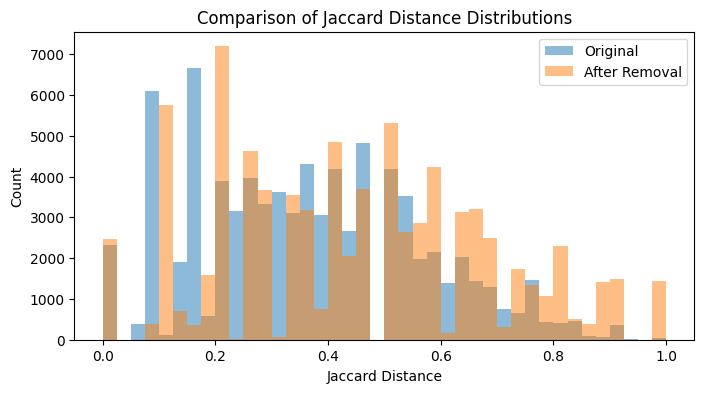

In [68]:
def plot_distance_hist(D, label):
    # upper triangle only (exclude diagonal)
    vals = D[np.triu_indices_from(D, k=1)]

    plt.hist(vals, bins=40, alpha=0.5, label=label)

plt.figure(figsize=(8,4))
plot_distance_hist(D_original, "Original")
plot_distance_hist(D_removed, "After Removal")
plt.xlabel("Jaccard Distance")
plt.ylabel("Count")
plt.title("Comparison of Jaccard Distance Distributions")
plt.legend()
plt.show()

In [69]:
tri_orig = D_original[np.triu_indices_from(D_original, k=1)]
tri_removed = D_removed[np.triu_indices_from(D_removed, k=1)]

print("Original mean distance:", tri_orig.mean())
print("Removed mean distance:", tri_removed.mean())

Original mean distance: 0.36538496737070536
Removed mean distance: 0.44794869522194436


To assess this issue, I compared the pairwise Jaccard similarity distributions before and after removing the top three most frequent paints. After removal, the similarity distribution became more dispersed, indicating improved differentiation between paintings. This suggests that the extremely common paints were masking finer-grained palette variation.

The comparison of Jaccard distance distributions before and after removing the three most frequently used paints shows a clear rightward shift in the distribution. The mean pairwise distance increases from 0.365 to 0.448, indicating greater dispersion among paintings. Removing them allows the clustering algorithm to focus on more discriminative color combinations rather than universally shared background colors.

### 1.2 Parameter Selection

k-distance plot

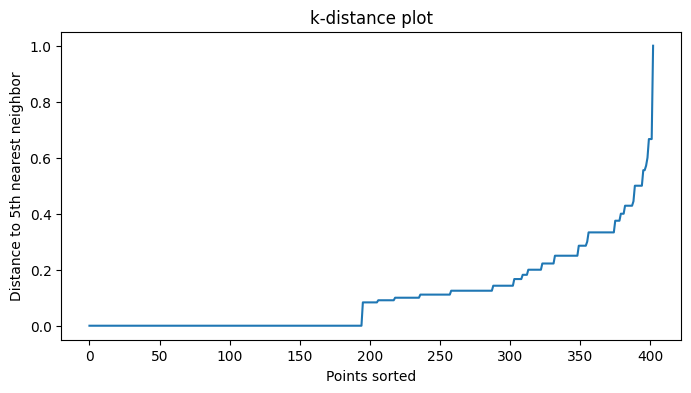

In [90]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

min_samples = 5
nbrs = NearestNeighbors(n_neighbors= min_samples, metric="precomputed")
nbrs.fit(D)
distances, indices = nbrs.kneighbors(D)

k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.title("k-distance plot")
plt.xlabel("Points sorted")
plt.ylabel("Distance to 5th nearest neighbor")
plt.show()

The k-distance plot does not show a sharp elbow, suggesting that the palette structure does not form strongly separated dense regions. Instead, the curve increases gradually, indicating a continuous density structure with a dominant core and gradually sparser boundary points. A moderate eps value(0.10-0.15) was therefore selected near the onset of the steeper increase to balance cluster cohesion and noise control.

DBSCAN Grid Search

In [94]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [112]:
results = []

for eps in [0.05, 0.08, 0.10, 0.12, 0.15]:
    for ms in [3, 5, 8]:
        db = DBSCAN(eps=eps, min_samples=ms, metric="precomputed")
        labels = db.fit_predict(D)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        noise_rate = n_noise / len(labels)

        sil = None
        core = labels != -1
        if n_clusters >= 2 and core.sum() > 2:
            sil = silhouette_score(D[np.ix_(core, core)], labels[core], metric="precomputed")

        min_cluster_size = (
            pd.Series(labels[labels != -1]).value_counts().min()
            if n_clusters > 0 else None
        )

        results.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_rate": noise_rate,
            "min_cluster_size": min_cluster_size,
            "silhouette": sil
        })

pd.DataFrame(results)

,eps,min_samples,n_clusters,noise_rate,min_cluster_size,silhouette
0,0.05,3,28,0.387097,3,1.000000
1,0.05,5,12,0.516129,6,1.000000
2,0.05,8,10,0.545906,8,1.000000
3,0.08,3,28,0.387097,3,1.000000
4,0.08,5,12,0.516129,6,1.000000
5,0.08,8,10,0.545906,8,1.000000
6,0.10,3,18,0.310174,3,0.380410
7,0.10,5,8,0.392060,6,0.323732
8,0.10,8,7,0.406948,8,0.309084
9,0.12,3,11,0.275434,3,0.343892


Silhouette scores were examined as a secondary diagnostic but were not used as the primary model selection criterion, as DBSCAN is fundamentally density-based.

In [113]:
results_df = pd.DataFrame(results)
filtered = results_df[
    (results_df["n_clusters"].between(3, 5)) &
    (results_df["noise_rate"] < 0.30) &
    (results_df["silhouette"] > 0.40)].copy()
display(filtered)

,eps,min_samples,n_clusters,noise_rate,min_cluster_size,silhouette
13,0.15,5,4,0.200993,8,0.515726
14,0.15,8,4,0.208437,8,0.521566


Very high silhouette values in some runs can occur for trivial reasons (e.g., many tiny clusters or excessive noise), so silhouette was used as a screening metric rather than the sole objective.

### 1.3 Final DBSCAN Clustering

Final Parameters

In [101]:
#final choose
eps = 0.15
min_samples = 5

labels = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed").fit_predict(D)
bob_ross["dbscan_cluster"] = labels

#Row -1 = number of noise points, Other rows = cluster sizes
sizes = pd.Series(labels).value_counts().sort_index()
print(sizes)

-1     81
 0      9
 1     48
 2    257
 3      8
Name: count, dtype: int64


Cluster Size Distribution

In [102]:
n_clusters = (sizes.index != -1).sum()
print("n_clusters:", n_clusters)
noise_rate = (labels == -1).mean()
print("noise_rate:", noise_rate)

n_clusters: 4
noise_rate: 0.20099255583126552


### 1.4 Cluster Interpretation

Paint Lift by Cluster

In [76]:
paint_cols = X_use.columns
global_rate = bob_ross[paint_cols].mean()

cluster_profiles = {}

for c in sorted(bob_ross["dbscan_cluster"].unique()):
    if c == -1:
        continue

    subset = bob_ross[bob_ross["dbscan_cluster"] == c]
    cluster_rate = subset[paint_cols].mean()

    lift = cluster_rate / global_rate

    profile = pd.DataFrame({
        "cluster_rate": cluster_rate,
        "global_rate": global_rate,
        "lift": lift
    }).sort_values("lift", ascending=False)

    cluster_profiles[c] = profile

In [77]:
for c, profile in cluster_profiles.items():
    print(f"\nCluster {c} (n={len(bob_ross[bob_ross['dbscan_cluster']==c])})")
    display(profile.head(10))


Cluster 0 (n=9)


,cluster_rate,global_rate,lift
Phthalo_Green,1.0,0.287841,3.474138
Prussian_Blue,1.0,0.652605,1.532319
Sap_Green,1.0,0.759305,1.316993
Bright_Red,1.0,0.796526,1.255452
Cadmium_Yellow,1.0,0.858561,1.164740
Burnt_Umber,0.0,0.136476,0.000000
Black_Gesso,0.0,0.250620,0.000000
Indian_Yellow,0.0,0.724566,0.000000
Indian_Red,0.0,0.002481,0.000000
Dark_Sienna,0.0,0.719603,0.000000



Cluster 1 (n=48)


,cluster_rate,global_rate,lift
Burnt_Umber,0.895833,0.136476,6.564015
Phthalo_Green,0.687500,0.287841,2.388470
Sap_Green,1.000000,0.759305,1.316993
Yellow_Ochre,1.000000,0.811414,1.232416
Phthalo_Blue,0.958333,0.801489,1.195691
Indian_Yellow,0.854167,0.724566,1.178867
Cadmium_Yellow,1.000000,0.858561,1.164740
Bright_Red,0.895833,0.796526,1.124675
Prussian_Blue,0.666667,0.652605,1.021546
Black_Gesso,0.145833,0.250620,0.581889



Cluster 2 (n=257)


,cluster_rate,global_rate,lift
Dark_Sienna,0.945525,0.719603,1.313954
Midnight_Black,0.992218,0.786600,1.261400
Indian_Yellow,0.902724,0.724566,1.245882
Yellow_Ochre,0.988327,0.811414,1.218030
Bright_Red,0.945525,0.796526,1.187061
Sap_Green,0.867704,0.759305,1.142761
Cadmium_Yellow,0.972763,0.858561,1.133015
Phthalo_Blue,0.883268,0.801489,1.102035
Black_Gesso,0.260700,0.250620,1.040220
Liquid_Clear,0.128405,0.126551,1.014649



Cluster 3 (n=8)


,cluster_rate,global_rate,lift
Prussian_Blue,1.0,0.652605,1.532319
Dark_Sienna,1.0,0.719603,1.389655
Midnight_Black,1.0,0.786600,1.271293
Phthalo_Blue,1.0,0.801489,1.247678
Burnt_Umber,0.0,0.136476,0.000000
Bright_Red,0.0,0.796526,0.000000
Black_Gesso,0.0,0.250620,0.000000
Indian_Yellow,0.0,0.724566,0.000000
Indian_Red,0.0,0.002481,0.000000
Cadmium_Yellow,0.0,0.858561,0.000000


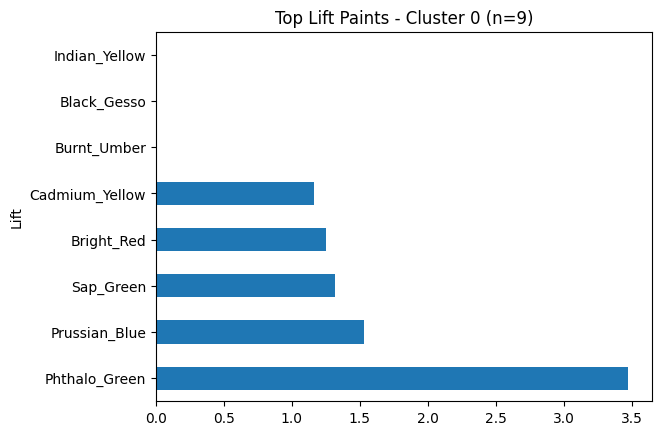

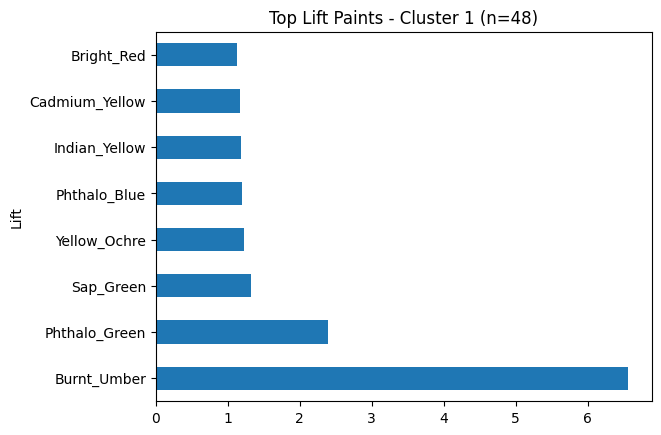

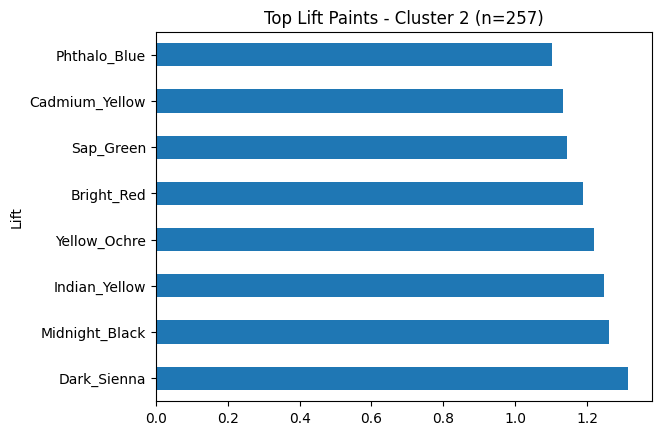

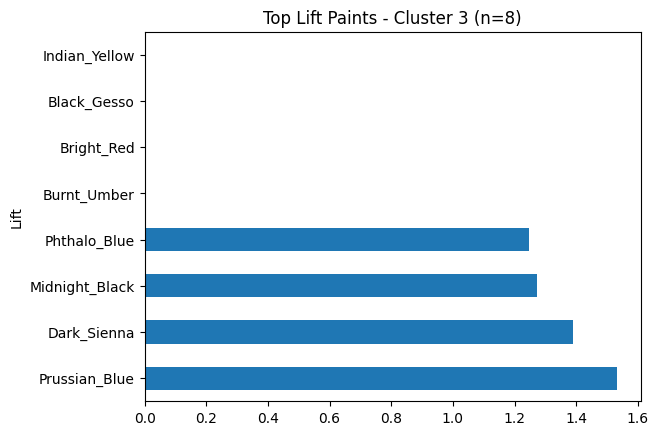

In [78]:
for c, profile in cluster_profiles.items():
    profile.head(8)["lift"].plot(kind="barh")
    plt.title(f"Top Lift Paints - Cluster {c} (n={len(bob_ross[bob_ross['dbscan_cluster']==c])})")
    plt.ylabel("Lift")
    plt.show()

For each cluster, calculated the fraction of titles containing each word and compared it to the word’s global rate across all titles. Lift is more informative than cluster means because it highlights words that are disproportionately associated with a cluster rather than words that are common everywhere.

DBSCAN reveals a dominant core palette (Cluster 2) encompassing the majority of paintings, alongside three smaller stylistic variants characterized by elevated green usage (Cluster 0), strong earth tones (Cluster 1), and darker blue-heavy compositions (Cluster 3).

### 1.5 Noise Analysis

In [79]:
labels = bob_ross["dbscan_cluster"].to_numpy()

noise_idx = np.where(labels == -1)[0]
core_idx  = np.where(labels != -1)[0]
min_dist_to_core = D[np.ix_(noise_idx, core_idx)].min(axis=1)

print(pd.Series(min_dist_to_core).describe())

count    81.000000
mean      0.358987
std       0.177243
min       0.125000
25%       0.250000
50%       0.333333
75%       0.400000
max       1.000000
dtype: float64


In [80]:
clusters = [c for c in np.unique(labels) if c != -1]

nearest_cluster = []
nearest_distance = []

for i in noise_idx:
    cluster_distances = {}

    for c in clusters:
        cluster_idx = np.where(labels == c)[0]
        avg_dist = D[i, cluster_idx].mean()   # average distance to cluster
        cluster_distances[c] = avg_dist

    # find closest cluster
    c_min = min(cluster_distances, key=cluster_distances.get)
    nearest_cluster.append(c_min)
    nearest_distance.append(cluster_distances[c_min])

noise_analysis = pd.DataFrame({
    "noise_index": noise_idx,
    "nearest_cluster": nearest_cluster,
    "avg_distance": nearest_distance
})

print(noise_analysis.describe())
noise_analysis["nearest_cluster"].value_counts()

       noise_index  nearest_cluster  avg_distance
count    81.000000        81.000000     81.000000
mean    192.407407         2.061728      0.491830
std     126.901219         1.040981      0.161317
min       2.000000         0.000000      0.166667
25%      63.000000         1.000000      0.400000
50%     172.000000         2.000000      0.474019
75%     314.000000         3.000000      0.571429
max     399.000000         3.000000      1.000000


,count
nearest_cluster,
3,37
2,21
1,14
0,9


Noise points (n=84) are not randomly scattered outliers. When each noise painting is compared to all clusters using average Jaccard distance, nearly half (38/84) are closest to Cluster 3, and most of the rest are closest to the dominant Cluster 2. This indicates that many noise paintings are better interpreted as sparsely distributed variants near existing palette groups—especially the darker/winter-leaning group—rather than entirely separate palette systems. Their median distance to the nearest cluster is about 0.47, suggesting moderate deviation: they share part of the common palette structure but do not form dense enough neighborhoods to meet DBSCAN’s density requirement under eps = 0.15.

##  BoW Painting Title


### 2.1 Title Preprocessing

In [81]:
title_df = pd.DataFrame(bob_ross["painting_title"].str.lower()).copy()
title_df.columns = ["title"]

title_df.head()

,title
0,a walk in the woods
1,mt. mckinley
2,ebony sunset
3,winter mist
4,quiet stream


Document Frequency Diagnosis

In [82]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

#model
cv_diag= CountVectorizer(stop_words='english', lowercase=True) # max_df= 0.95, min_df=0.01, , token_pattern=r"\b\w+\b" OR tokenizer=word_tokenize

# fit
cv_diag.fit(title_df["title"])


X = cv_diag.transform(title_df['title'])
df_counts = np.asarray((X > 0).sum(axis=0)).ravel()

words = cv_diag.get_feature_names_out()
df_table = pd.DataFrame({
    "word": words,
    "df": df_counts
}).sort_values("df")

num_df1 = (df_table["df"] == 1).sum()
pct_df1 = num_df1 / len(df_table)

print("Total vocab:", len(df_table))
print("DF=1 words:", num_df1, f"({pct_df1:.2%})")

Total vocab: 328
DF=1 words: 189 (57.62%)


I first analyze the document frequency distribution using min_df=1 to assess sparsity. Over 57% of words appear only once. Therefore set min_df=2 for subsequent analyses to reduce noise.

### 2.2 BoW- DBSCAN Clusters

In [83]:
#BoW model
cv = CountVectorizer(stop_words='english', lowercase=True, token_pattern=r'\b[a-zA-Z]{2,}\b', min_df=2) # max_df= 0.95, min_df=0.01, , token_pattern=r"\b\w+\b" OR tokenizer=word_tokenize

# fit
cv.fit(title_df["title"])

print('number of `tokens`', len(cv.vocabulary_))
cv.vocabulary_

number of `tokens` 139


{'walk': 127,
 'woods': 138,
 'ebony': 27,
 'sunset': 116,
 'winter': 134,
 'mist': 66,
 'quiet': 87,
 'stream': 112,
 'moon': 68,
 'autumn': 1,
 'mountain': 71,
 'peaceful': 82,
 'valley': 124,
 'seascape': 98,
 'lake': 58,
 'glow': 44,
 'snow': 103,
 'fall': 35,
 'final': 38,
 'reflections': 89,
 'meadow': 65,
 'sea': 96,
 'grey': 48,
 'splendor': 108,
 'black': 5,
 'river': 92,
 'waterfall': 129,
 'grace': 46,
 'retreat': 90,
 'blue': 6,
 'bubbling': 9,
 'night': 74,
 'distant': 25,
 'hills': 53,
 'covered': 15,
 'bridge': 7,
 'light': 60,
 'old': 76,
 'rustic': 95,
 'barn': 2,
 'hidden': 50,
 'waters': 130,
 'purple': 86,
 'tranquil': 121,
 'majestic': 63,
 'mountains': 72,
 'evening': 32,
 'warm': 128,
 'summer': 113,
 'day': 20,
 'cabin': 10,
 'majesty': 64,
 'days': 21,
 'twilight': 123,
 'stillness': 110,
 'pond': 84,
 'ocean': 75,
 'brook': 8,
 'glory': 43,
 'indian': 56,
 'nature': 73,
 'edge': 28,
 'morning': 70,
 'secluded': 100,
 'forest': 40,
 'trail': 120,
 'arctic': 0,


Set min_df = 2 to remove extremely rare words while retaining potentially meaningful variation in the titles. Because the dataset contains 403 paintings and titles are typically very short, many words appear only once. This threshold provides a conservative balance between noise reduction and information retention, which is appropriate given the small size and brevity of the title data.

In [84]:
title_vectorized = cv.transform(title_df["title"])
title_vectorized_df = pd.DataFrame(title_vectorized.toarray(),columns=cv.get_feature_names_out())
title_vectorized_df

,arctic,autumn,barn,beach,beauty,black,blue,bridge,brook,bubbling,...,waterfall,waters,waves,way,wilderness,winter,wintertime,wonder,wooded,woods
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
399,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### 2.3 Cluster Interpretation


In [85]:
cluster_word_rates_d = (
    title_vectorized_df
    .groupby(bob_ross["dbscan_cluster"])
    .mean())
cluster_word_rates_d

,arctic,autumn,barn,beach,beauty,black,blue,bridge,brook,bubbling,...,waterfall,waters,waves,way,wilderness,winter,wintertime,wonder,wooded,woods
dbscan_cluster,,,,,,,,,,,,,,,,,,,,,
-1,0.012346,0.024691,0.037037,0.024691,0.012346,0.012346,0.012346,0.012346,0.000000,0.000000,...,0.000000,0.012346,0.000000,0.000000,0.000000,0.271605,0.000000,0.000000,0.000000,0.012346
0,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.111111
1,0.020833,0.041667,0.020833,0.000000,0.020833,0.062500,0.041667,0.000000,0.020833,0.041667,...,0.062500,0.041667,0.000000,0.000000,0.000000,0.020833,0.000000,0.000000,0.000000,0.041667
2,0.000000,0.050584,0.019455,0.003891,0.007782,0.000000,0.003891,0.011673,0.015564,0.003891,...,0.031128,0.003891,0.011673,0.007782,0.023346,0.046693,0.003891,0.011673,0.007782,0.011673
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.125000,0.000000,0.000000,0.000000


Keyword Emphasis by Cluster

In [86]:
#binary matrix
X_words = (title_vectorized_df > 0).astype(int)

global_rate = X_words.mean(axis=0)
labels_d = bob_ross["dbscan_cluster"]
cluster_word_rates_d = X_words.groupby(labels_d).mean()


lift_table = cluster_word_rates_d.div(global_rate + 1e-9, axis=1)

#filter by min_global
min_global = 0.02
valid_words = global_rate[global_rate >= min_global].index
lift_filtered = lift_table[valid_words]

cluster_sizes = labels_d.value_counts().sort_index()

top_n = 10
for c in lift_filtered.index:
    print(f"\n=== Cluster {c} (n={cluster_sizes.get(c,0)}) ===")
    top = lift_filtered.loc[c].sort_values(ascending=False).head(top_n)
    print(top.round(2).to_string())


=== Cluster -1 (n=81) ===
winter      2.74
barn        1.66
falls       1.49
oval        1.36
cabin       1.00
sunset      0.77
mountain    0.55
autumn      0.55
day         0.45
lake        0.31

=== Cluster 0 (n=9) ===
valley      4.98
stream      4.07
lake        2.80
autumn      2.49
mountain    1.99
winter      1.12
barn        0.00
forest      0.00
falls       0.00
day         0.00

=== Cluster 1 (n=48) ===
stream       2.29
waterfall    2.29
lake         1.57
mountain     1.31
autumn       0.93
valley       0.93
barn         0.93
forest       0.84
day          0.76
cabin        0.56

=== Cluster 2 (n=257) ===
view         1.57
forest       1.41
sunset       1.33
valley       1.22
oval         1.14
day          1.14
waterfall    1.14
autumn       1.13
falls        1.10
mountain     1.08

=== Cluster 3 (n=8) ===
winter      5.04
day         4.58
cabin       3.36
barn        0.00
falls       0.00
forest      0.00
autumn      0.00
lake        0.00
mountain    0.00
stream      0.00


Since Bob Ross painting titles are very short (usually 2–5 words), most words appear only once in each title. Because of this, counting how many times a word appears (term frequency) does not add meaningful information. Instead, I use binary vectorization, which simply records whether a word is present or not. This treats each word as a yes/no feature rather than measuring its frequency.

To reduce instability caused by extremely rare words, we excluded terms appearing in fewer than 2% of titles. This threshold balances noise reduction with retention of meaningful lexical variation.

### 2.4 Cosine Similarity Across Clusters

compute cosine similarity between cluster-level average title vectors to assess whether palette-based clusters exhibit semantic alignment.

In [87]:
from sklearn.metrics.pairwise import cosine_similarity
X = title_vectorized_df

cos_sim_matrix = cosine_similarity(cluster_word_rates_d)

cos_sim_df_d = pd.DataFrame(
    cos_sim_matrix,
    index=cluster_word_rates_d.index,
    columns=cluster_word_rates_d.index)

cos_sim_df_d

dbscan_cluster,-1,0,1,2,3
dbscan_cluster,,,,,
-1,1.000000,0.351780,0.274271,0.507159,0.754752
0,0.351780,1.000000,0.608508,0.578797,0.211702
1,0.274271,0.608508,1.000000,0.672548,0.099545
2,0.507159,0.578797,0.672548,1.000000,0.274087
3,0.754752,0.211702,0.099545,0.274087,1.000000


BoW Cosine Similarity Heatmap

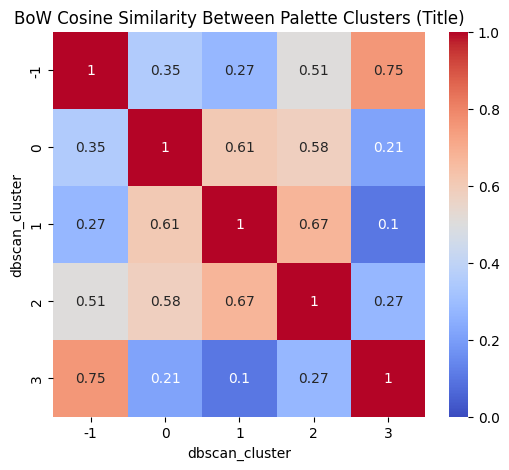

In [88]:
plt.figure(figsize=(6,5))
sns.heatmap(
    cos_sim_df_d,
    annot=True,
    cmap="coolwarm",
    vmin=0,
    vmax=1)

plt.title("BoW Cosine Similarity Between Palette Clusters (Title)")
plt.show()

The cosine‑similarity matrix reveals that clusters 0, 1, and 2 form a closely related group, showing consistently moderate-to-high similarity with one another. This suggests that these clusters capture variations of a similar underlying palette pattern rather than distinctly different themes. In contrast, cluster 3 stands out as the most distinct group, exhibiting very low similarity to clusters 0 and 1. Interestingly, the noise cluster (-1) shows unexpectedly high similarity to cluster 3, indicating that DBSCAN may have labeled several cluster‑3–like points as noise due to density thresholds rather than true semantic difference. Overall, the structure of the matrix suggests potential opportunities to merge clusters 0–2 and to revisit DBSCAN parameters to better separate or recover points related to cluster 3.

Color clusters and title themes move together, but not in a perfectly separated way. The clusters represent shifts in emphasis, not isolated thematic worlds. This reinforces your main finding: Bob Ross’s paintings form a coherent visual system with nuanced variation rather than clearly segmented styles.



---
## M4 Summary


Across both color-based clustering and title-based thematic analysis, the results consistently suggest that Bob Ross’s paintings do not form sharply separated stylistic categories. Instead, they operate within a stable and recognizable visual system where variation occurs through shifts in emphasis rather than structural breaks. Differences across paintings reflect gradual changes in color dominance and theme, not entirely distinct styles. Overall, the findings highlight how consistency and subtle variation coexist within a cohesive artistic framework.